In [4]:
import numpy as np
import os
import scipy
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
import itertools
wandb.login()
pd.set_option('display.max_rows', 200)
plotting_context = "paper"
default_palette = "colorblind"
granularity_palette = sns.color_palette('coolwarm', 2)
local_sps_palette = sns.color_palette("Set2", 3)
cv_palette = sns.color_palette("YlOrRd", 5)
nlp_palette = sns.color_palette("YlGnBu", 3)
font_scale = 1.5
sns.set(font_scale=font_scale, context=plotting_context)
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
WANDB_ENTITY = "kubework"
WANDB_PROJECT = "paper-2023"

def get_env(var):
    val = os.getenv(var)
    if val == None:
        raise ValueError(f"Environment variable {var} is not set. Please follow the README.md instructions and start the notebook with all environment variables set.")
    else:
        print(f"{var}:{val}")
    return val

LOG_PATH=get_env("LOG_PATH")
NETWORK_PATH=get_env("NETWORK_LOG_PATH")
FIGURE_PATH=get_env("FIGURE_PATH")

def save_figure(name, local_fig_dir, file_type='pdf'):
    '''Save matplotlib figures at a local directory based on the full hardcoded path
    :param name: str - name of the pdf figure (e.g., "throughput")
    :param local_fig_dir: str - plots are saved under a subdirectory based on the pipeline (e.g., "image-pipeline")
    '''
    figure_path   = FIGURE_PATH
    full_fig_dir  = figure_path + "/" + local_fig_dir
    full_fig_path = full_fig_dir + "/" + name + "." + file_type
    dpi = 300
    plt.savefig(full_fig_path, dpi=dpi, bbox_inches = "tight")
    
def save_fig(name, file_type='pdf'):
    save_figure(name, local_fig_dir="misc", file_type=file_type)

LOG_PATH:../../artifacts/wandb
NETWORK_LOG_PATH:../../artifacts/networking/logs
FIGURE_PATH:../../paper/figures


In [5]:
api = wandb.Api()

def get_runs(run_name: str):
    """
    """
    entity = WANDB_ENTITY
    project = WANDB_PROJECT
    path = entity + "/" + project
    key = "config.run_name"
    filters = { key: run_name }
    return api.runs(path=path, filters=filters)

def get_history_non_cached(run, keys):
    history = run.scan_history(keys=keys)
    output = []
    for row in history:
        row_output = {}
        for key in keys:
            row_output[key] = row[key]
        output.append(row_output)
    return pd.DataFrame(output)

def get_history(run, cache=True):
    run_name = run.config.get("run_name")
    host_name = run.config.get("host")
    history_run_path = f"{LOG_PATH}/{run_name}-{host_name}.csv"
    if cache and os.path.isfile(history_run_path):
        return pd.read_csv(history_run_path)
    else:
        history = run.scan_history()
        dataframe_content = []
        for row in history:
            dataframe_content.append(row)
        df = pd.DataFrame(dataframe_content)
        df.to_csv(history_run_path, index=False)
        return df

def get_run_by_prefix(runs, prefix):
    prefixed_runs = []
    for run in runs:
        if run.name.startswith(prefix):
            prefixed_runs.append(run)
    print(f"> Found {len(prefixed_runs)} runs with the prefix '{prefix}'.")
    return prefixed_runs

def get_run_by_infix(runs, infix):
    infixed_runs = []
    for run in runs:
        if infix in run.name:
            infixed_runs.append(run)
    print(f"> Found {len(infixed_runs)} runs with the infix '{infix}'.")
    return infixed_runs

def get_clean_history(run, filter_by="hivemind", cache=True):
    """Tries to fix the two async wandb threads that logged together.
    :filter_by:
        - "hivemind": tries to fix the history
        - "hardware": returns the history without fixing, as we don't need perfect sync here
    """
    history_df = get_history(run, cache=cache)
    if "baseline" in run.config.get("run_name"):
        additional_keys = ['01_general/step_based_sps']
    else:
        additional_keys = ['03_hivemind/num_peers',
                           '03_hivemind/global_epoch']
    if filter_by == "hivemind":
        keys = ['01_general/locally_processed_samples',
                '01_general/lr',
                '01_general/step',
                #'01_general/minibatch_loss', # loss.item() was too often None for NLP baseline, non NaN
                '01_general/dataset_iteration_count',
                '02_timing/dataload_time_s',
                '02_timing/dataload_cuda_move_time_s',
                '02_timing/forward_time_s',
                '02_timing/backward_time_s',
                '02_timing/loss_calc_time_s',
                '02_timing/opt_step_time_s',
                '02_timing/step_time_s', 
                '_step',
                '_runtime',
                ] + additional_keys
        filtered_history_df = history_df[keys]
        return merge_rows(df=filtered_history_df, ignore_cols=['_step','_runtime'])
    elif filter_by == "hardware":
        keys = [
            'memory/total_memory_sys_MB',
            'memory/used_memory_sys_MB',
            'memory/available_memory_sys_MB',
            'memory/used_memory_sys_percent',
            'process/memory/virtual_memory_size_proc_MB',
            'process/memory/text_resident_set_proc_MB', 
            'process/memory/shared_memory_proc_MB',
            'process/memory/dirty_pages_proc_count',
            'process/memory/data_resident_set_proc_MB',
            'process/memory/resident_set_size_proc_MB',
            'process/memory/lib_memory_proc_MB',
            'process/voluntary_proc_ctx_switches',
            'process/involuntary_proc_ctx_switches',
            'bandwidth/disk_read_sys_bandwidth_MBs',
            'bandwidth/disk_write_sys_bandwidth_MBs',
            'bandwidth/net_sent_sys_bandwidth_Mbits',
            'bandwidth/net_recv_sys_bandwidth_Mbits',
            'disk/time/disk_busy_time_sys_s',
            'disk/time/disk_write_time_sys_s',
            'disk/time/disk_read_time_sys_s',
            'disk/counter/disk_read_sys_count',
            'disk/counter/disk_write_sys_count',
            'cpu/interrupts/ctx_switches_count',
            'cpu/interrupts/soft_interrupts_count',
            'cpu/logical_core_count',
            'cpu/interrupts/interrupts_count',
            'cpu/load/avg_sys_load_one_min_percent',
            'cpu/load/avg_sys_load_five_min_percent',
            'cpu/load/avg_sys_load_fifteen_min_percent',
            '_step',
            '_runtime',
        ]
        return history_df[keys]
    else:
        raise ValueError(f"filter_by: {filter_by} not known.")

def merge_rows(df, ignore_cols):
    """Merges rows with interleaved NaNs.
    rowA = [1,     2, NaN,   4, NaN]
    rowB = [NaN, NaN,   3, NaN,   5]
    => result [1, 2, 3, 4, 5]
    
    :df: pd.DataFrame to be merged
    :ignore_cols: list(), keys in this list are merged by using the max(valA, valB) value, e.g. "_step"
    :returns: pd.DataFrame which is merged
    """
    # 1. Drop all full NaN rows
    temp_df = df.dropna(how="all")
    # 2. Iterate over all the rows by keeping a temp row which is filled successivley
    clean_rows = []
    prev_row = None
    cleaned_row_counter = 0
    for ix, row in temp_df.iterrows():
        row_dict = dict(row)
        # 2.1 If the temporary row is commited, start with the new row
        if prev_row == None:
            # 2.1.1 If the new row has NaN values, set it "to be completed"
            if any_values_are_nan(row_dict):
                prev_row = row_dict
            else:
            # 2.1.2 If the new row is complete, commit it
                clean_rows.append(row_dict)
        # 2.2 If we have a row to be completed, try to fill the values with the next row
        else:
            temp_row = merge_dicts(dictA=prev_row, dictB=row, ignore_cols=ignore_cols)
            # 2.2.1 If there are still NaNs, keep it for next processing
            if any_values_are_nan(temp_row):
                prev_row = temp_row
            # 2.2.2 If no NaNs exist anymore, commit and prepare for next row
            else:
                clean_rows.append(temp_row)
                prev_row = None
    return pd.DataFrame(clean_rows)

def merge_dicts(dictA, dictB, ignore_cols):
    """Merges two dicts together by filling the NaN values.
    If not in :ignore_cols: and both values are non NaN, an exception is thrown.
    Both dicts have the same keys.
    :dictA: dict()
    :dictB: dict()
    :ignore_cols: list(), the value of these keys will be decided by a max(a,b)
    :returns: dict()
    """
    result = {}
    for key in dictA:     
        if key in ignore_cols and \
            not math.isnan(dictA[key]) and \
            not math.isnan(dictB[key]):
            result[key] = max(dictA[key], dictB[key])
        else:
            try:
                result[key] = return_non_nan(dictA[key], dictB[key])
            except ValueError:
                print(f"Values ({dictA[key]}) and ({dictB[key]}) for key ({key}) are neither NaN, picking max.")
                result[key] = max(dictA[key], dictB[key])
    return result

def any_values_are_nan(dictionary):
    """
    """
    return any([math.isnan(dictionary[key]) for key in dictionary])
        
def return_non_nan(a, b):
    if math.isnan(a) and math.isnan(b):
        return a
    if math.isnan(a) and not math.isnan(b):
        return b
    if not math.isnan(a) and math.isnan(b):
        return a
    if not math.isnan(a) and not math.isnan(b):
        raise ValueError(f"Tuple (a,b) of ({a}, {b}) are neither NaN.")

def round_bar_value_multi(ax, decimals=2):
    for containers in ax.containers:
        for container in containers:
            container.set_height(round(container.get_height(), decimals))
        ax.bar_label(containers)
        
def show_values_on_barplot(plot, height, rotation=0, decimals=2, fontsize="large"):
    for i, p in enumerate(ax.patches):
        additional_height = height if i % 2 == 0 else height*2
        org_height = p.get_height()
        text = f"{round(org_height, decimals)}"
        ax.text(p.get_x() + (p.get_width()/10.0),
                p.get_height() + additional_height,
                text,
                color='black',
                rotation=rotation,
                fontsize=fontsize)

In [6]:
def get_baseline_runs(run_names, keys=["01_general/step_based_sps"]):
    baseline_runs = [get_runs(run_name=run_name)[0] for run_name in run_names]
    baseline_dfs = []
    for run in baseline_runs:
        baseline_df = get_clean_history(run = run, filter_by="hivemind")
        baseline_df = baseline_df[keys]
        baseline_df["name"] = "-".join(run.config.get("run_name").split(".")[0].split("-")[:2])
        if "torchvision" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split(".")[-1]
        if "roberta" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split("-")[-1]
        baseline_df["TBS"] = run.config.get("batch_size_per_step") * run.config.get("gradient_accumulation_steps")
        baseline_df = baseline_df.rename(columns={"01_general/step_based_sps": "samples_per_sec"})
        baseline_dfs.append(baseline_df)
    return pd.concat(objs=baseline_dfs)

def get_hivemind_runs(run_names, drop_first_epoch=True):
    
    hivemind_176_add = False
    # adding manually as W&B API does not see this run because it was deleted and restored
    if "hivemind-176" in run_names:
        run_names.remove("hivemind-176")
        hivemind_176_add = True
        
    hivemind_runs = [get_run_by_prefix(
                        runs = get_runs(run_name = run_name),
                        prefix = "trainmonitor")[0]
                     for run_name in run_names]
    if hivemind_176_add:
        # trainmonitor-176
        hivemind_runs.append(api.run(path="kubework/paper-2023/1e4zlzpd"))
    hivemind_dfs = []
    
    keys = ["03_hivemind/optimistic_total_samples_per_second",
            "03_hivemind/epoch_based_sps"]
    
    for run in hivemind_runs:
        hivemind_df = get_history(run = run)
        hivemind_df = hivemind_df[keys]
        hivemind_df["name"] = run.config.get("run_name")
        hivemind_df["model"] = run.config.get("model").split(".")[-1]
        hivemind_df["TBS"] = run.config.get("target_batch_size")
        hivemind_df = hivemind_df.rename(columns={"03_hivemind/epoch_based_sps": "samples_per_sec"})
        hivemind_df = hivemind_df.rename(columns={"03_hivemind/optimistic_total_samples_per_second": "local samples_per_sec"})
        if drop_first_epoch:
            # get index of the first epoch value
            first_index = hivemind_df.query("samples_per_sec.notna()").index[0]
            # get index of last epoch value
            last_index = hivemind_df.query("samples_per_sec.notna()").index[-1]
            # start the dataframe from the next value
            hivemind_df = hivemind_df[first_index+1:last_index+1]
        hivemind_dfs.append(hivemind_df)
    return pd.concat(objs=hivemind_dfs)

def rename_models(df):
    df = df.replace("resnet18", "ResNet18")
    df = df.replace("resnet50", "ResNet50")
    df = df.replace("resnet152", "ResNet152")
    df = df.replace("wide_resnet101_2", "WideResNet101_2")
    df = df.replace("convnext_large", "ConvNextLarge")
    df = df.replace("roberta_mlm_base", "RoBERTaBase")
    df = df.replace("roberta_mlm_large", "RoBERTaLarge")
    df = df.replace("roberta_mlm_xlm", "RoBERTaXLM")
    return df

def compute_local_step_cutoff(df, debug=False):
    """We get a unimodal time series with 3 outliers (sync steps)
    Returning a cutoff where all of the outliers are included.
    """
    median = df.median()
    std = df.std()
    cutoff = median + 2*std # 95% of all data should be included here
    if debug:
        print(f">> Found {len(df.index[df >= cutoff].tolist())} sync steps: {df[df >= cutoff].tolist()}")
    return cutoff

def get_aggregated_step_timings(df, agg = "sum", clean = True, debug = False):
    
    # 02_timing/dataload_time_s - unimodal with one startup outlier
    # 02_timing/dataload_cuda_move_time_s - unimodal
    # 02_timing/forward_time_s - unimodal
    # 02_timing/loss_calc_time_s - unimodal
    # 02_timing/backward_time_s - unimodal
    # 02_timing/opt_step_time_s - bi/tri-modal
    # 02_timing/step_time_s - bi/tri-modal
    
    agg_dict = {}
    # opt_step_time_data.plot.hist()    
    # opt.step() is basically a no-op
    
    # detect the outliers (sync-steps) and decide on a cutoff
    # which includes all of them (the fastest sync step)
    NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(df["02_timing/opt_step_time_s"], debug=debug)
        
    # exclude the first hivemind epoch from logging
    if clean:
        averaging_ix = df.index[df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()
        #assert(len(averaging_ix) >= 2), f"At least 2x averaging indices should be included: {averaging_ix}"
        first_averaging_ix = averaging_ix[0] + 1 # starting from the next step
        cleaned_df = df[first_averaging_ix:]
    else:
        cleaned_df = df
    
    opt_step_time_data = cleaned_df["02_timing/opt_step_time_s"]
    
    if agg == "sum":
        agg_dict["dataload_s"] = cleaned_df["02_timing/dataload_time_s"].sum()
        agg_dict["cuda_move_s"] = cleaned_df["02_timing/dataload_cuda_move_time_s"].sum()
        agg_dict["forward_s"] = cleaned_df["02_timing/forward_time_s"].sum()
        agg_dict["loss_calc_s"] = cleaned_df["02_timing/loss_calc_time_s"].sum()
        agg_dict["backward_s"] = cleaned_df["02_timing/backward_time_s"].sum()
        agg_dict["opt_step_local_s"] = opt_step_time_data[opt_step_time_data < NON_LOCAL_STEP_CUTOFF_S].sum()
        agg_dict["opt_step_sync_s"] = opt_step_time_data[opt_step_time_data >= NON_LOCAL_STEP_CUTOFF_S].sum()
    elif agg == "mean":
        agg_dict["dataload_s"] = cleaned_df["02_timing/dataload_time_s"].mean()
        agg_dict["cuda_move_s"] = cleaned_df["02_timing/dataload_cuda_move_time_s"].mean()
        agg_dict["forward_s"] = cleaned_df["02_timing/forward_time_s"].mean()
        agg_dict["loss_calc_s"] = cleaned_df["02_timing/loss_calc_time_s"].mean()
        agg_dict["backward_s"] = cleaned_df["02_timing/backward_time_s"].mean()
        agg_dict["opt_step_local_s"] = opt_step_time_data[opt_step_time_data < NON_LOCAL_STEP_CUTOFF_S].mean()
        agg_dict["opt_step_sync_s"] = opt_step_time_data[opt_step_time_data >= NON_LOCAL_STEP_CUTOFF_S].mean()
         
    # wrap in lists for pandas df creation
    for key in agg_dict.keys(): agg_dict[key] = [agg_dict[key]]
    
    return pd.DataFrame(agg_dict)

def hivemind_run_step_breakdown(run_name: str, agg = "sum", debug=False):
    # filter all runs by workers
    hivemind_runs = get_run_by_infix(
        runs = get_runs(run_name = run_name),
        infix = "bee")
    
    aggregated_dfs = []
    
    # aggregate gpu runs
    for gpu_run in hivemind_runs:
        gpu_agg_df = get_aggregated_step_timings(
            df=get_clean_history(
                run=gpu_run, filter_by="hivemind"),
            agg=agg,
            debug=debug)
        gpu_agg_df["name"] = gpu_run.config.get("host")
        aggregated_dfs.append(gpu_agg_df)
    
    return pd.concat(objs=aggregated_dfs)

def hivemind_run_step_breakdown_concatenated(run_name: str, debug=False):
    # filter all runs by workers
    hivemind_runs = get_run_by_infix(
        runs = get_runs(run_name = run_name),
        infix = "bee")
    
    timing_keys = [
        "02_timing/dataload_time_s",
        "02_timing/dataload_cuda_move_time_s",
        "02_timing/forward_time_s",
        "02_timing/backward_time_s",
        "02_timing/loss_calc_time_s",
        "02_timing/opt_step_time_s",
        "name"
    ]
    
    non_sync_list = []
    sync_list = []
    
    # aggregate gpu runs
    for gpu_run in hivemind_runs:
        
        gpu_run_df = get_clean_history(run=gpu_run, filter_by="hivemind")
        NON_LOCAL_STEP_CUTOFF_S = compute_local_step_cutoff(gpu_run_df["02_timing/opt_step_time_s"], debug=debug)
        print(NON_LOCAL_STEP_CUTOFF_S)
        averaging_ix = gpu_run_df.index[gpu_run_df["02_timing/opt_step_time_s"] >= NON_LOCAL_STEP_CUTOFF_S].tolist()
        print(averaging_ix)
        non_sync_df = gpu_run_df.drop(index=averaging_ix)
        non_sync_df["name"] = gpu_run.config.get("host")
        
        sync_df = gpu_run_df.iloc[averaging_ix] 
        
        sync_df["name"] = gpu_run.config.get("host")
        
        non_sync_list.append(non_sync_df[timing_keys])
        sync_list.append(sync_df[timing_keys])
    
    full_non_sync_df = pd.concat(objs=non_sync_list)
    full_non_sync_df = full_non_sync_df.reset_index(drop=True)
    full_sync_df = pd.concat(objs=sync_list)
    full_sync_df = full_sync_df.reset_index(drop=True)
    return full_non_sync_df, full_sync_df

# Hivemind Penalty Analysis

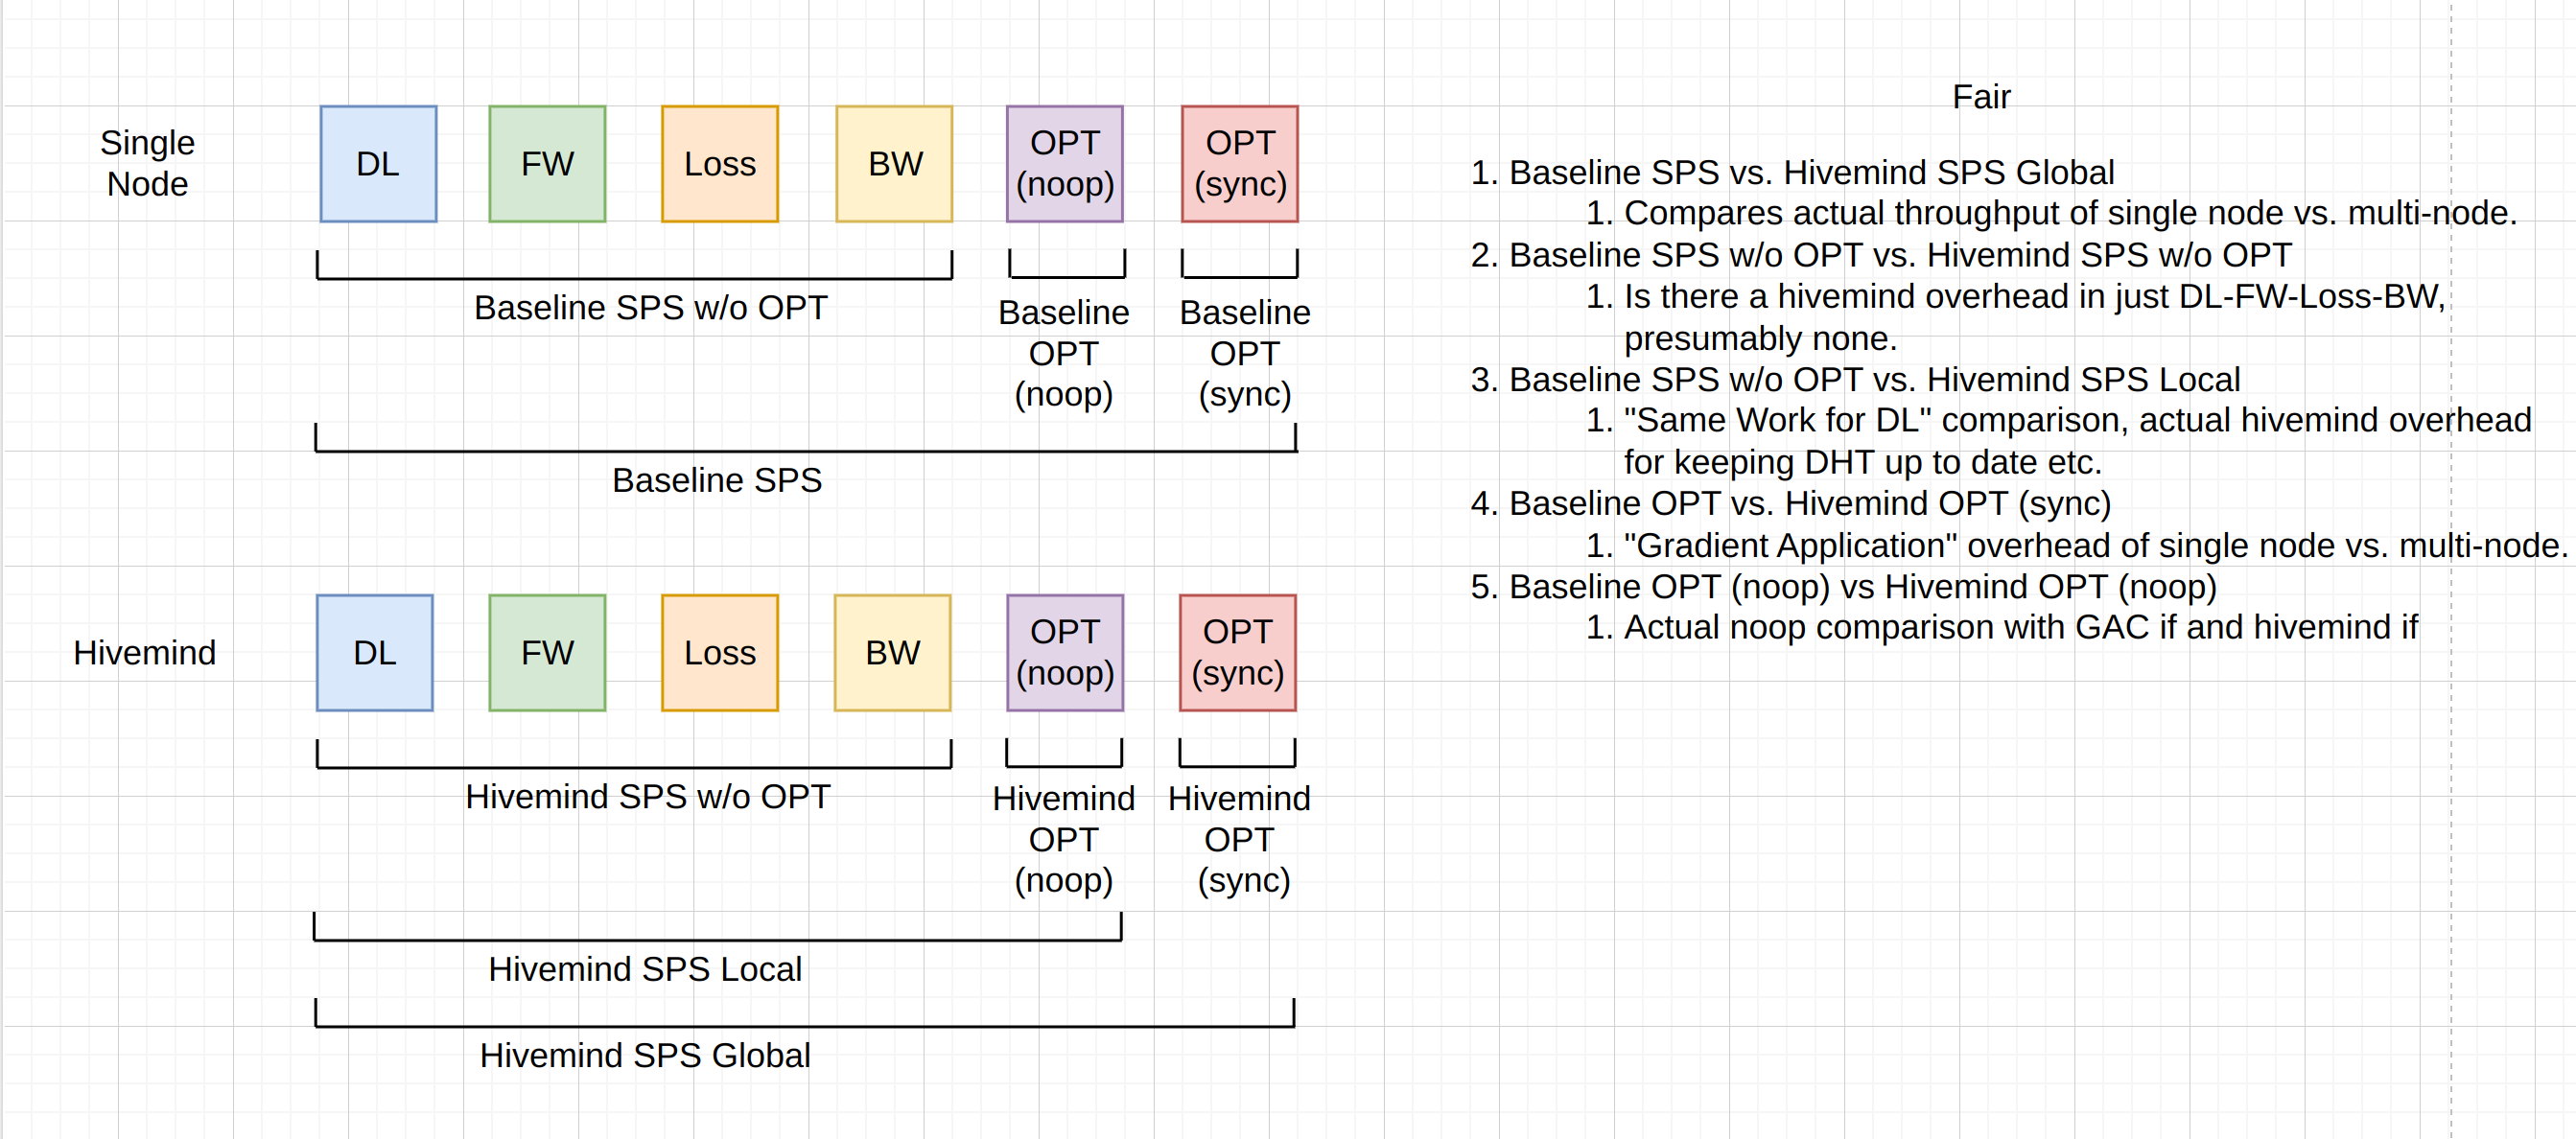

```
        "01_general/locally_processed_samples",
        "01_general/step_based_sps",
        "02_timing/dataload_time_s",
        "02_timing/dataload_cuda_move_time_s",
        "02_timing/forward_time_s",
        "02_timing/loss_calc_time_s",
        "02_timing/backward_time_s",
        "02_timing/opt_step_time_s",
```

In [7]:
def get_baseline_runs_full_timing(run_names):
    keys = [
        "01_general/locally_processed_samples",
        "01_general/step_based_sps",
        "02_timing/dataload_time_s",
        "02_timing/dataload_cuda_move_time_s",
        "02_timing/forward_time_s",
        "02_timing/loss_calc_time_s",
        "02_timing/backward_time_s",
        "02_timing/opt_step_time_s",        
    ]
    baseline_runs = [get_runs(run_name=run_name)[0] for run_name in run_names]
    baseline_dfs = []
    for run in baseline_runs:
        baseline_df = get_clean_history(run = run, filter_by="hivemind")
        baseline_df = baseline_df[keys]
        baseline_df["name"] = "-".join(run.config.get("run_name").split(".")[0].split("-")[:2])
        if "torchvision" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split(".")[-1]
        if "roberta" in run.config.get("run_name"):
            baseline_df["model"] = run.config.get("run_name").split("-")[-1]
        baseline_df["TBS"] = run.config.get("batch_size_per_step") * run.config.get("gradient_accumulation_steps")
        baseline_df = baseline_df.rename(columns={"01_general/step_based_sps": "samples_per_sec"})
        baseline_dfs.append(baseline_df)
    return pd.concat(objs=baseline_dfs)

def create_timing_summary(df):
    agg_dict = {}
    agg_dict["traintime_wo_opt"] = df["dataload_s"].mean() + \
                                       df["cuda_move_s"].mean() + \
                                       df["forward_s"].mean() + \
                                       df["loss_calc_s"].mean() + \
                                       df["backward_s"].mean()
    agg_dict["noop_opt"] = df["opt_step_local_s"].mean()
    agg_dict["sync_opt"] = df["opt_step_sync_s"].mean()
    agg_dict["forward_s"] = df["forward_s"].mean()
    agg_dict["backward_s"] = df["backward_s"].mean()
# wrap in lists for pandas df creation
    for key in agg_dict.keys(): agg_dict[key] = [agg_dict[key]]
    return pd.DataFrame(agg_dict)

def auto_baseline_timing_summary(run_name, agg="mean"):
    baseline_df = get_baseline_runs_full_timing(run_names=[run_name])
    baseline_step_timing_df = get_aggregated_step_timings(df=baseline_df, clean=False, agg=agg)
    baseline_processed_timing_df = create_timing_summary(df=baseline_step_timing_df)
    baseline_processed_timing_df["name"] = baseline_df["name"][0]
    baseline_processed_timing_df["model"] = baseline_df["model"][0]
    baseline_processed_timing_df["TBS"] = baseline_df["TBS"][0]
    return baseline_processed_timing_df

def auto_baseline_timing_summaries(run_names, agg="mean"):
    temp_list = []
    for run_name in run_names:
        df = auto_baseline_timing_summary(run_name=run_name, agg=agg)
        temp_list.append(df)
    result_df = pd.concat(objs=temp_list)
    return result_df.reset_index(drop=True)
    
def auto_hivemind_timing_summary(run_name, val_dict, agg="mean"):
    temp_timing_df = hivemind_run_step_breakdown(run_name=run_name, agg="mean")
    temp_timing_summary_df = create_timing_summary(df=temp_timing_df)
    #mean_df = df.mean(numeric_only=True).to_frame().T
    for key, val in val_dict.items():
        temp_timing_summary_df[key] = val
    temp_timing_summary_df["name"] = run_name
    return temp_timing_summary_df

def auto_hivemind_timing_concatenated_summary(run_name, val_dict):
    non_sync_df, sync_df = hivemind_run_step_breakdown_concatenated(run_name=run_name)
    for key, val in val_dict.items():
        non_sync_df[key] = val
        sync_df[key] = val
    non_sync_df["name"] = run_name
    sync_df["name"] = run_name
    return non_sync_df, sync_df

# CV

In [8]:
cv_a10_baseline_timing_df = auto_baseline_timing_summaries(run_names=[
    "baseline-161-torchvision.models.resnet18", #"baseline-0-torchvision.models.resnet18",
    "baseline-162-torchvision.models.resnet18", #"baseline-1-torchvision.models.resnet18",
    "baseline-163-torchvision.models.resnet18", #"baseline-2-torchvision.models.resnet18",
    "baseline-164-torchvision.models.resnet50", #"baseline-3-torchvision.models.resnet50",
    "baseline-165-torchvision.models.resnet50", #"baseline-4-torchvision.models.resnet50",
    "baseline-166-torchvision.models.resnet50", #"baseline-5-torchvision.models.resnet50",
    "baseline-6-torchvision.models.resnet152",
    "baseline-7-torchvision.models.resnet152",
    "baseline-8-torchvision.models.resnet152",
    "baseline-9-torchvision.models.wide_resnet101_2",
    "baseline-10-torchvision.models.wide_resnet101_2",
    "baseline-11-torchvision.models.wide_resnet101_2",
    "baseline-12-torchvision.models.convnext_large",
    "baseline-191-torchvision.models.convnext_large",
    "baseline-192-torchvision.models.convnext_large",
    ])
cv_a10_baseline_timing_df = rename_models(df = cv_a10_baseline_timing_df)
cv_a10_baseline_timing_df["gpu_count"] = int(1)
cv_a10_baseline_timing_df["gpu_type"] = "A10"

#rn18_2xA10_4096_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-238", val_dict={"model": "ResNet18",       "TBS": 4096})
#rn50_2xA10_4096_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-239", val_dict={"model": "ResNet50",       "TBS": 4096})
#rn101_2xA10_4096_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-240",  val_dict={"model": "ResNet152",      "TBS": 4096})
#wdrn101_2xA10_4096_timing_df = auto_hivemind_timing_summary(run_name="hivemind-241",  val_dict={"model": "WideResNet101_2","TBS": 4096})
#conv_2xA10_4096_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-242",  val_dict={"model": "ConvNextLarge",  "TBS": 4096})

rn18_2xA10_8192_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-282", val_dict={"model": "ResNet18",       "TBS": 8192})
rn50_2xA10_8192_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-285", val_dict={"model": "ResNet50",       "TBS": 8192})
rn101_2xA10_8192_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-286",  val_dict={"model": "ResNet152",      "TBS": 8192})
wdrn101_2xA10_8192_timing_df = auto_hivemind_timing_summary(run_name="hivemind-291",  val_dict={"model": "WideResNet101_2","TBS": 8192})
conv_2xA10_8192_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-292",  val_dict={"model": "ConvNextLarge",  "TBS": 8192})

rn18_2xA10_16384_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-283", val_dict={"model": "ResNet18",       "TBS": 16384})
rn50_2xA10_16384_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-287", val_dict={"model": "ResNet50",       "TBS": 16384})
rn101_2xA10_16384_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-288",  val_dict={"model": "ResNet152",      "TBS": 16384})
wdrn101_2xA10_16384_timing_df = auto_hivemind_timing_summary(run_name="hivemind-293",  val_dict={"model": "WideResNet101_2","TBS": 16384})
conv_2xA10_16384_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-294",  val_dict={"model": "ConvNextLarge",  "TBS": 16384})

rn18_2xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-284", val_dict={"model": "ResNet18",       "TBS": 32768})
rn50_2xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-289", val_dict={"model": "ResNet50",       "TBS": 32768})
rn101_2xA10_32768_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-290",  val_dict={"model": "ResNet152",      "TBS": 32768})
wdrn101_2xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-295",  val_dict={"model": "WideResNet101_2","TBS": 32768})
conv_2xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-296",  val_dict={"model": "ConvNextLarge",  "TBS": 32768})

#rn18_2xA10_65536_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-235", val_dict={"model": "ResNet18",       "TBS": 65536})
#rn50_2xA10_65536_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-233", val_dict={"model": "ResNet50",       "TBS": 65536})
#rn101_2xA10_65536_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-234",  val_dict={"model": "ResNet152",      "TBS": 65536})
#wdrn101_2xA10_65536_timing_df = auto_hivemind_timing_summary(run_name="hivemind-236",  val_dict={"model": "WideResNet101_2","TBS": 65536})
#conv_2xA10_65536_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-237",  val_dict={"model": "ConvNextLarge",  "TBS": 65536})

cv_2x10_timings_df = pd.concat(objs=[
    #rn18_2xA10_4096_timing_df,
    #rn50_2xA10_4096_timing_df,
    #rn101_2xA10_4096_timing_df,
    #wdrn101_2xA10_4096_timing_df,
    #conv_2xA10_4096_timing_df,
    rn18_2xA10_8192_timing_df,
    rn50_2xA10_8192_timing_df,
    rn101_2xA10_8192_timing_df,
    wdrn101_2xA10_8192_timing_df,
    conv_2xA10_8192_timing_df,
    rn18_2xA10_16384_timing_df,
    rn50_2xA10_16384_timing_df,
    rn101_2xA10_16384_timing_df,
    wdrn101_2xA10_16384_timing_df,
    conv_2xA10_16384_timing_df,
    rn18_2xA10_32768_timing_df,
    rn50_2xA10_32768_timing_df,
    rn101_2xA10_32768_timing_df,
    wdrn101_2xA10_32768_timing_df,
    conv_2xA10_32768_timing_df,
    #rn18_2xA10_65536_timing_df,
    #rn50_2xA10_65536_timing_df,
    #rn101_2xA10_65536_timing_df,
    #wdrn101_2xA10_65536_timing_df,
    #conv_2xA10_65536_timing_df
])
cv_2x10_timings_df = cv_2x10_timings_df.reset_index(drop=True)
cv_2x10_timings_df["gpu_count"] = int(2)
cv_2x10_timings_df["gpu_type"] = "A10"

rn18_3xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-306", val_dict={"model": "ResNet18",       "TBS": 32768})
rn50_3xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-307", val_dict={"model": "ResNet50",       "TBS": 32768})
rn101_3xA10_32768_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-308",  val_dict={"model": "ResNet152",      "TBS": 32768})
wdrn101_3xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-309",  val_dict={"model": "WideResNet101_2","TBS": 32768})
conv_3xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-310",  val_dict={"model": "ConvNextLarge",  "TBS": 32768})
cv_3x10_timings_df = pd.concat(objs=[
    rn18_3xA10_32768_timing_df,
    rn50_3xA10_32768_timing_df,
    rn101_3xA10_32768_timing_df,
    wdrn101_3xA10_32768_timing_df,
    conv_3xA10_32768_timing_df
])
cv_3x10_timings_df = cv_3x10_timings_df.reset_index(drop=True)
cv_3x10_timings_df["gpu_count"] = int(3)
cv_3x10_timings_df["gpu_type"] = "A10"

rn18_4xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-315", val_dict={"model": "ResNet18",       "TBS": 32768})
rn50_4xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-316", val_dict={"model": "ResNet50",       "TBS": 32768})
rn101_4xA10_32768_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-317",  val_dict={"model": "ResNet152",      "TBS": 32768})
wdrn101_4xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-318",  val_dict={"model": "WideResNet101_2","TBS": 32768})
conv_4xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-319",  val_dict={"model": "ConvNextLarge",  "TBS": 32768})
cv_4x10_timings_df = pd.concat(objs=[
    rn18_4xA10_32768_timing_df,
    rn50_4xA10_32768_timing_df,
    rn101_4xA10_32768_timing_df,
    wdrn101_4xA10_32768_timing_df,
    conv_4xA10_32768_timing_df
])
cv_4x10_timings_df = cv_4x10_timings_df.reset_index(drop=True)
cv_4x10_timings_df["gpu_count"] = int(4)
cv_4x10_timings_df["gpu_type"] = "A10"

rn18_8xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-325", val_dict={"model": "ResNet18",       "TBS": 32768})
rn50_8xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-326", val_dict={"model": "ResNet50",       "TBS": 32768})
rn101_8xA10_32768_timing_df   = auto_hivemind_timing_summary(run_name="hivemind-327",  val_dict={"model": "ResNet152",      "TBS": 32768})
wdrn101_8xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-328",  val_dict={"model": "WideResNet101_2","TBS": 32768})
conv_8xA10_32768_timing_df    = auto_hivemind_timing_summary(run_name="hivemind-330",  val_dict={"model": "ConvNextLarge",  "TBS": 32768})
cv_8x10_timings_df = pd.concat(objs=[
    rn18_8xA10_32768_timing_df,
    rn50_8xA10_32768_timing_df,
    rn101_8xA10_32768_timing_df,
    wdrn101_8xA10_32768_timing_df,
    conv_8xA10_32768_timing_df
])
cv_8x10_timings_df = cv_8x10_timings_df.reset_index(drop=True)
cv_8x10_timings_df["gpu_count"] = int(8)
cv_8x10_timings_df["gpu_type"] = "A10"

cv_A10_timing_df = pd.concat(objs=[
    cv_a10_baseline_timing_df,
    cv_2x10_timings_df,
    cv_3x10_timings_df,
    cv_4x10_timings_df,
    cv_8x10_timings_df
])
cv_A10_timing_df= cv_A10_timing_df.reset_index(drop=True)
cv_A10_timing_df["sync_opt_norm"] = cv_A10_timing_df["sync_opt"] / cv_A10_timing_df["TBS"]
cv_A10_timing_df

> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
>

,traintime_wo_opt,noop_opt,sync_opt,forward_s,backward_s,name,model,TBS,gpu_count,gpu_type,sync_opt_norm
0,0.028824,0.000002,0.001413,0.007161,0.008061,baseline-161,ResNet18,8192,1,A10,1.725304e-07
1,0.027836,0.000002,0.001457,0.007253,0.008349,baseline-162,ResNet18,16384,1,A10,8.895010e-08
2,0.028170,0.000002,0.001328,0.007197,0.008145,baseline-163,ResNet18,32768,1,A10,4.052637e-08
3,0.043028,0.000002,0.002980,0.019153,0.016730,baseline-164,ResNet50,8192,1,A10,3.638179e-07
4,0.042860,0.000002,0.003132,0.019124,0.016568,baseline-165,ResNet50,16384,1,A10,1.911356e-07
5,0.042553,0.000002,0.003355,0.018870,0.016437,baseline-166,ResNet50,32768,1,A10,1.023827e-07
6,0.112101,0.000002,0.022963,0.055571,0.047781,baseline-6,ResNet152,8192,1,A10,2.803081e-06
7,0.109720,0.000002,0.021596,0.055273,0.045717,baseline-7,ResNet152,16384,1,A10,1.318137e-06
8,0.110196,0.000002,0.014305,0.055208,0.045979,baseline-8,ResNet152,32768,1,A10,4.365548e-07
9,0.076725,0.000002,0.052944,0.037255,0.031444,baseline-9,WideResNet101_2,8192,1,A10,6.462833e-06


# CV Training Time without `opt.step()` over GPUS

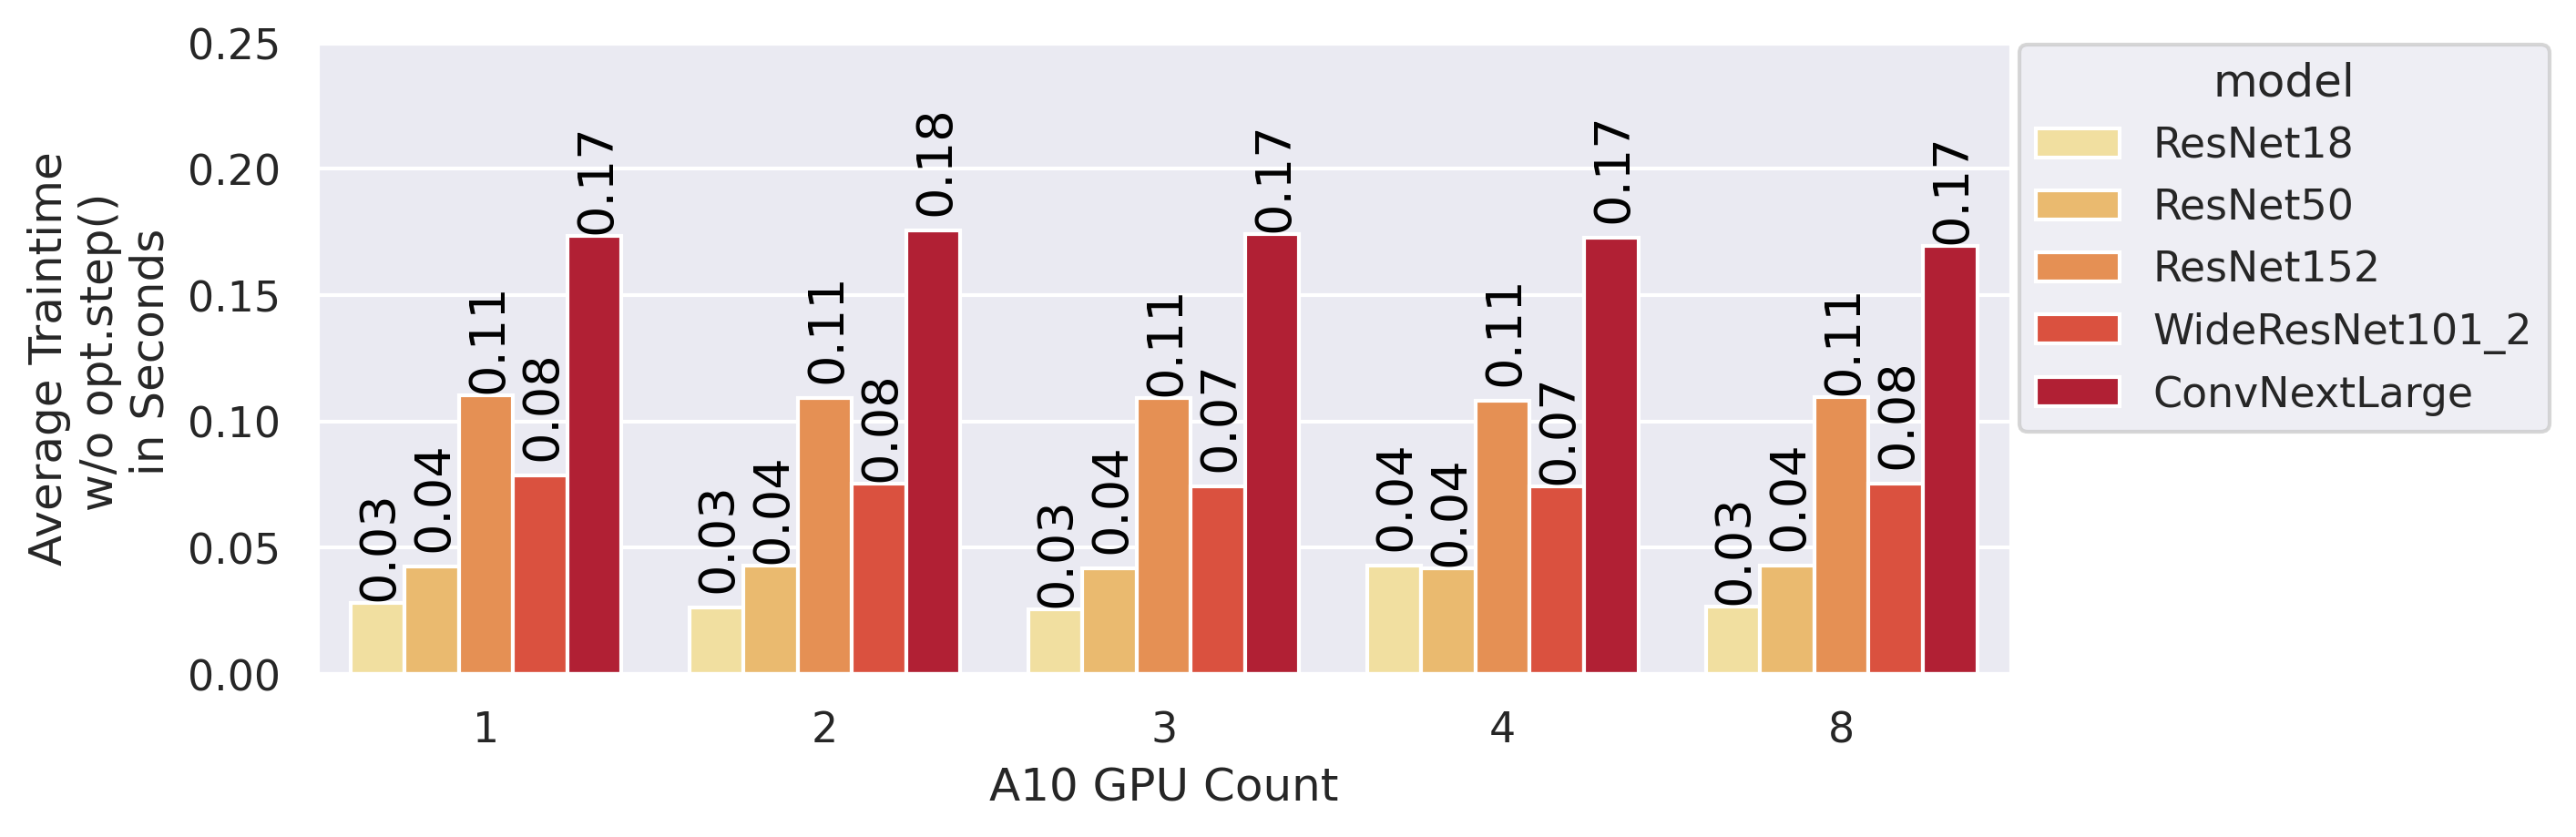

In [9]:
sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=cv_A10_timing_df.query("TBS==32768"),
    x="gpu_count",
    y="traintime_wo_opt",
    hue="model")
plt.ylabel("Average Traintime\n w/o opt.step()\n in Seconds")
plt.xlabel("A10 GPU Count")
plt.ylim(0,0.25)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
show_values_on_barplot(ax, height=0.005, rotation=90, decimals=2, fontsize=13)

## Over TBS

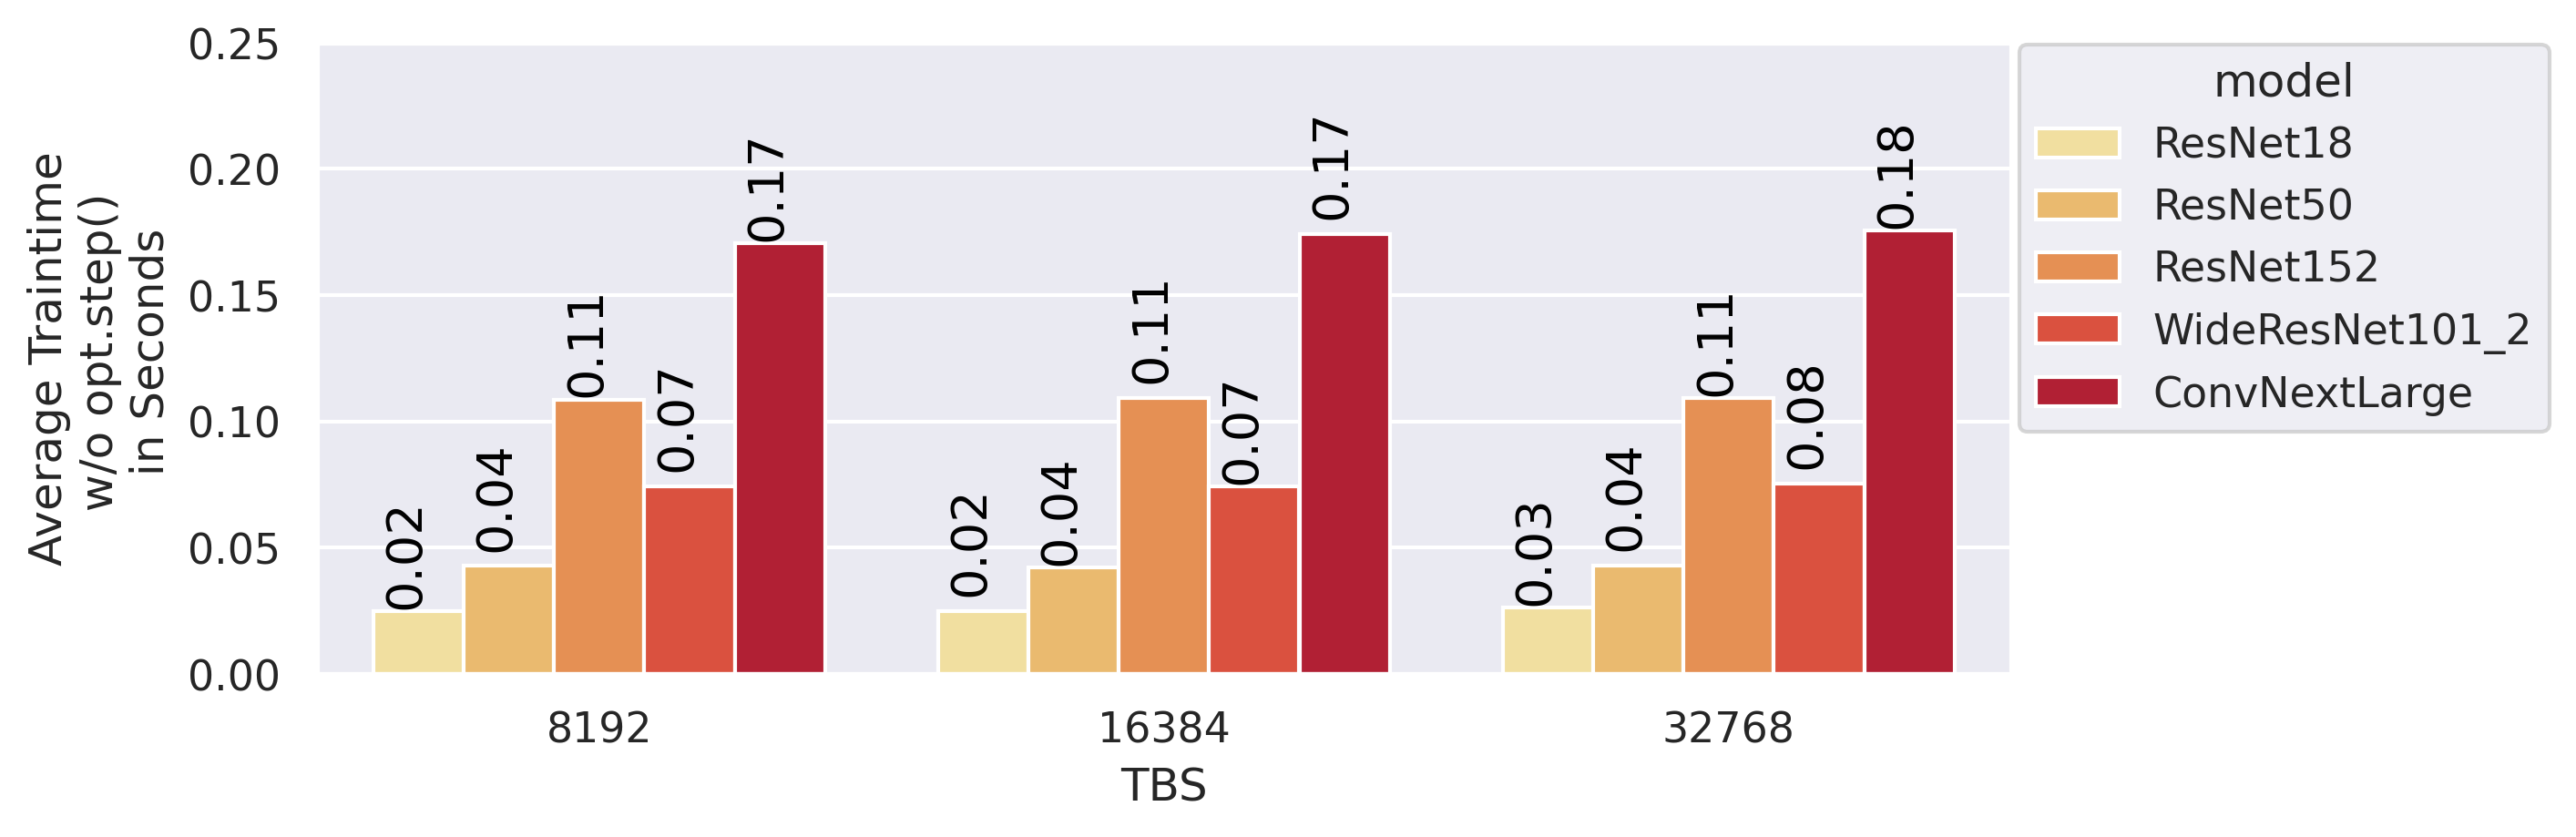

In [10]:
sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=cv_A10_timing_df.query("gpu_count==2"),
    x="TBS",
    y="traintime_wo_opt",
    hue="model")
plt.ylabel("Average Traintime\n w/o opt.step()\n in Seconds")
plt.xlabel("TBS")
plt.ylim(0,0.25)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
show_values_on_barplot(ax, height=0.005, rotation=90, decimals=2, fontsize=13)

# CV no-op `opt.step()` time over GPUs

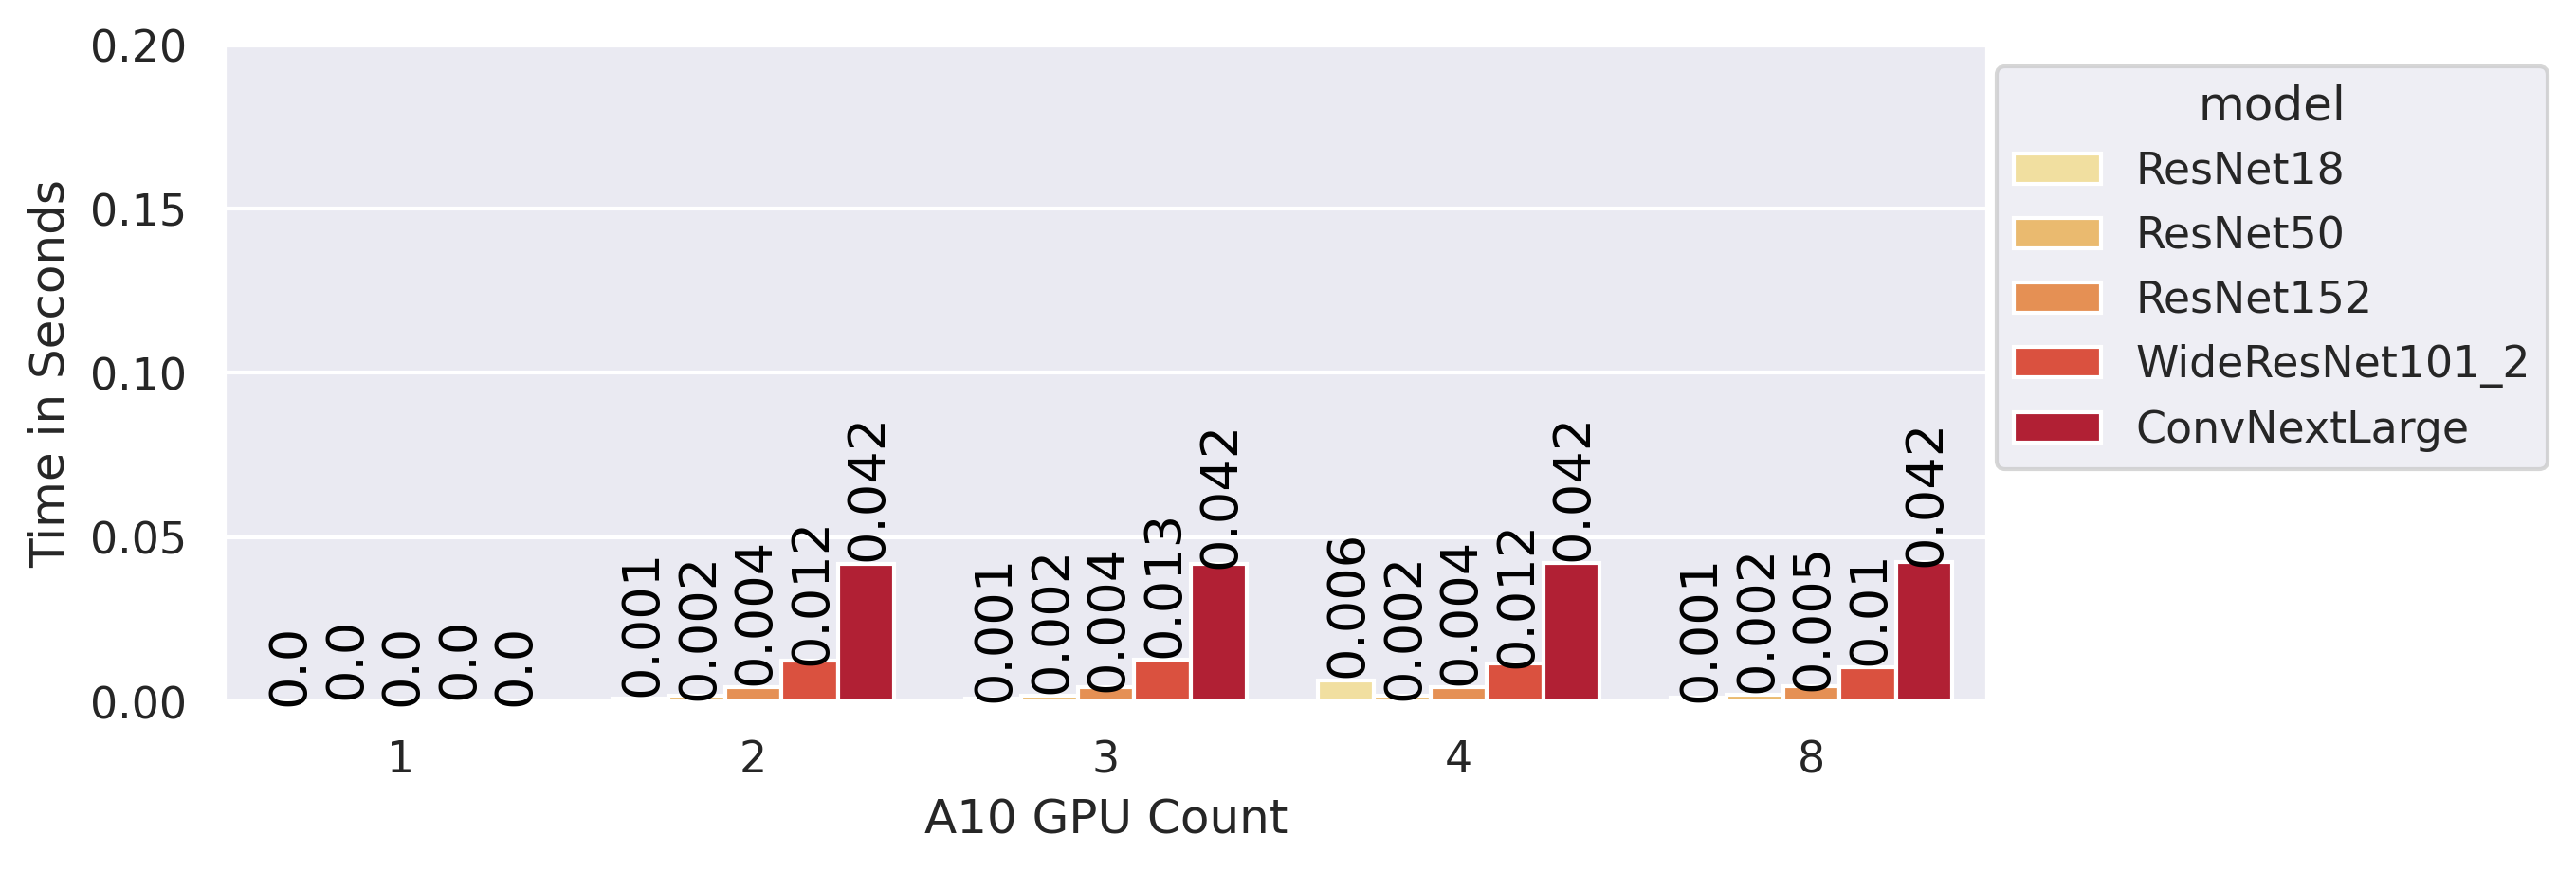

In [11]:
sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=cv_A10_timing_df.query("TBS==32768"),# and gpu_count!=1"),
    x="gpu_count",
    #y="backward_s",
    y="noop_opt",
    hue="model")
    #log=True)
#plt.ylabel("No-Sync opt.step()\n Time in Seconds")
plt.ylabel("Time in Seconds")
plt.xlabel("A10 GPU Count")
#plt.ylim(0.000001,0.08)
plt.ylim(0, 0.2)
#plt.title("No-Sync opt.step() Call Timing")
#plt.title("loss.backward() Call Timing")
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33,1))
#plt.legend(title="Model")
show_values_on_barplot(ax, height=0.002, rotation=90, decimals=3, fontsize=13)
#save_fig(f"cv_32768_noop_step")

## Over TBS

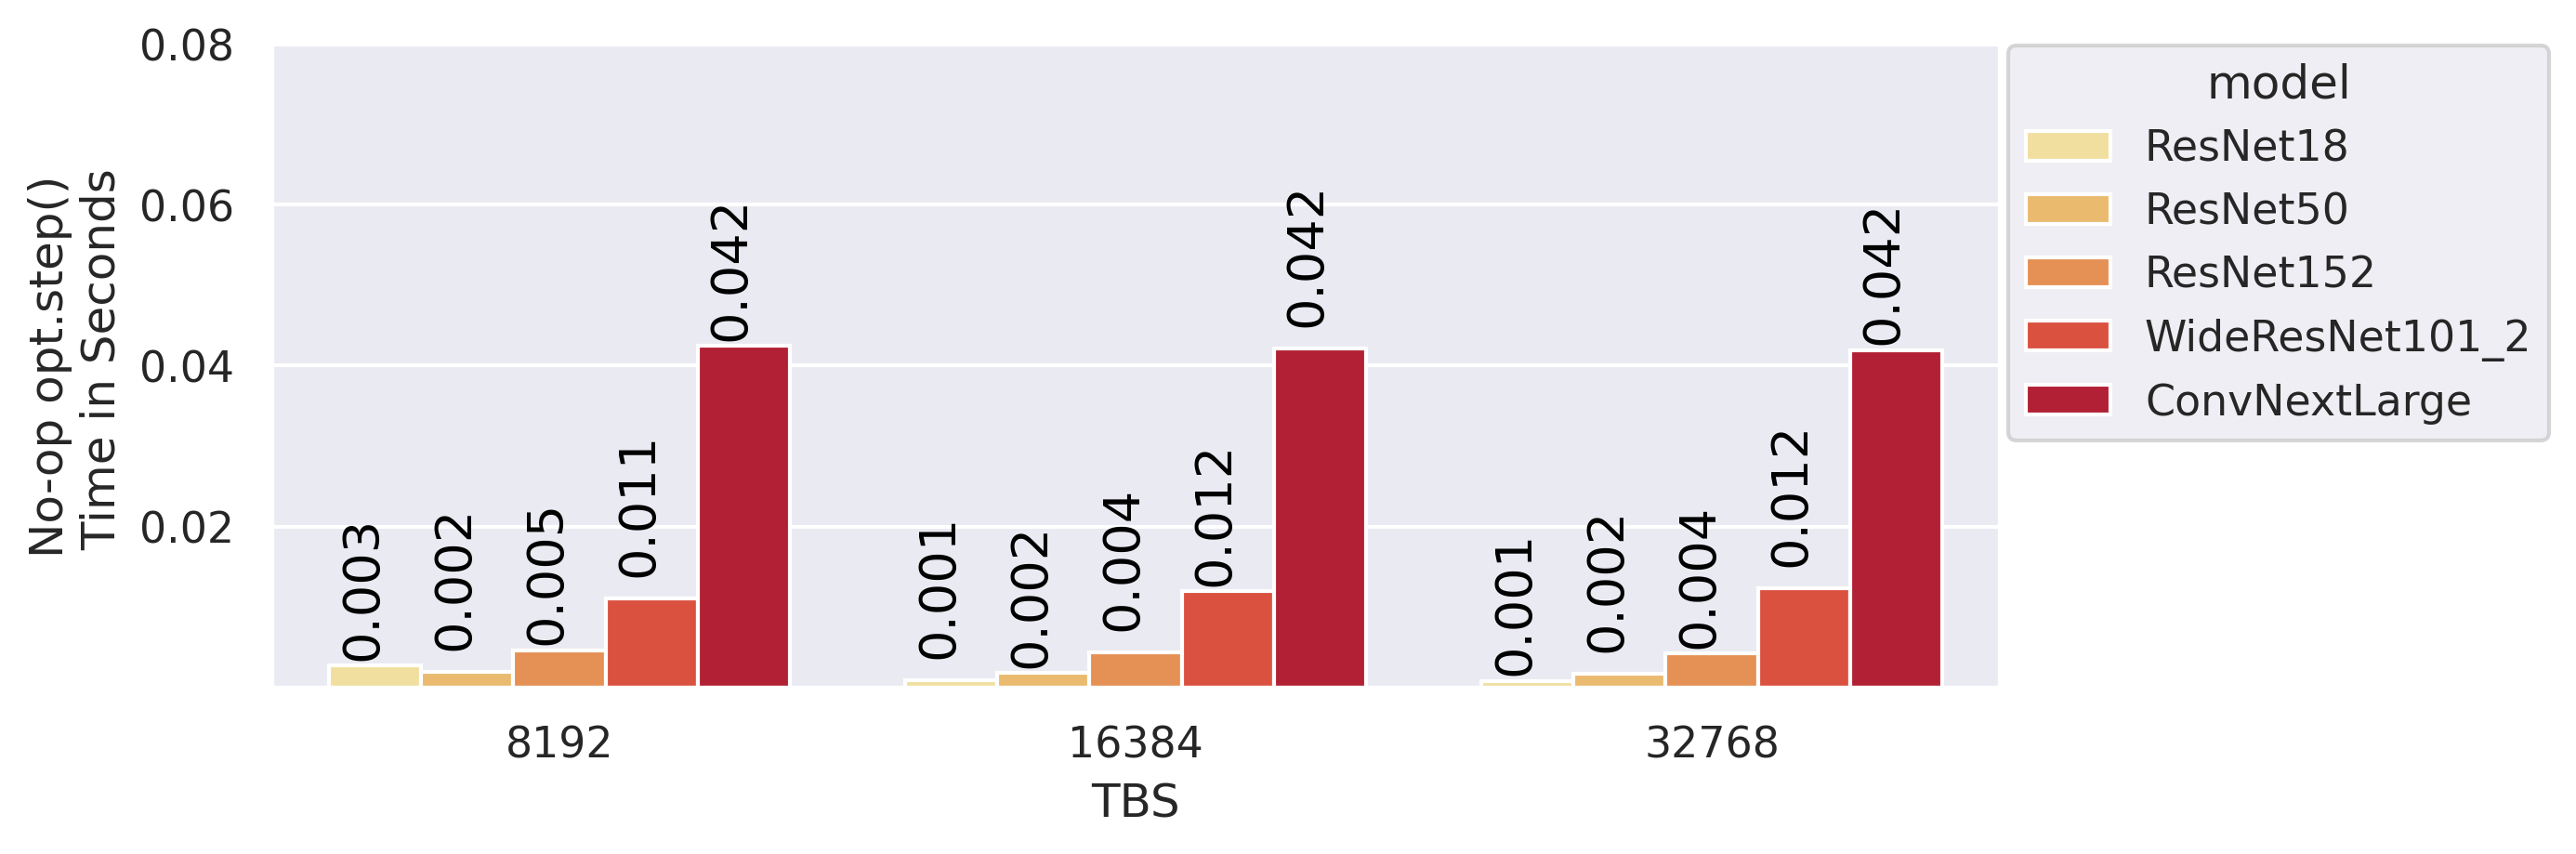

In [12]:
sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=cv_A10_timing_df.query("gpu_count==2"),
    x="TBS",
    y="noop_opt",
    hue="model")
plt.ylabel("No-op opt.step()\n Time in Seconds")
plt.xlabel("TBS")
plt.ylim(0.000001,0.08)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
#round_bar_value_multi(ax, decimals=2)
show_values_on_barplot(ax, height=0.002, rotation=90, decimals=3, fontsize=13)

# CV sync `opt.step()` time over GPUs

/tmp/ipykernel_23052/850360109.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["norm_sync_opt"] = temp_df["sync_opt"] / temp_df["gpu_count"]


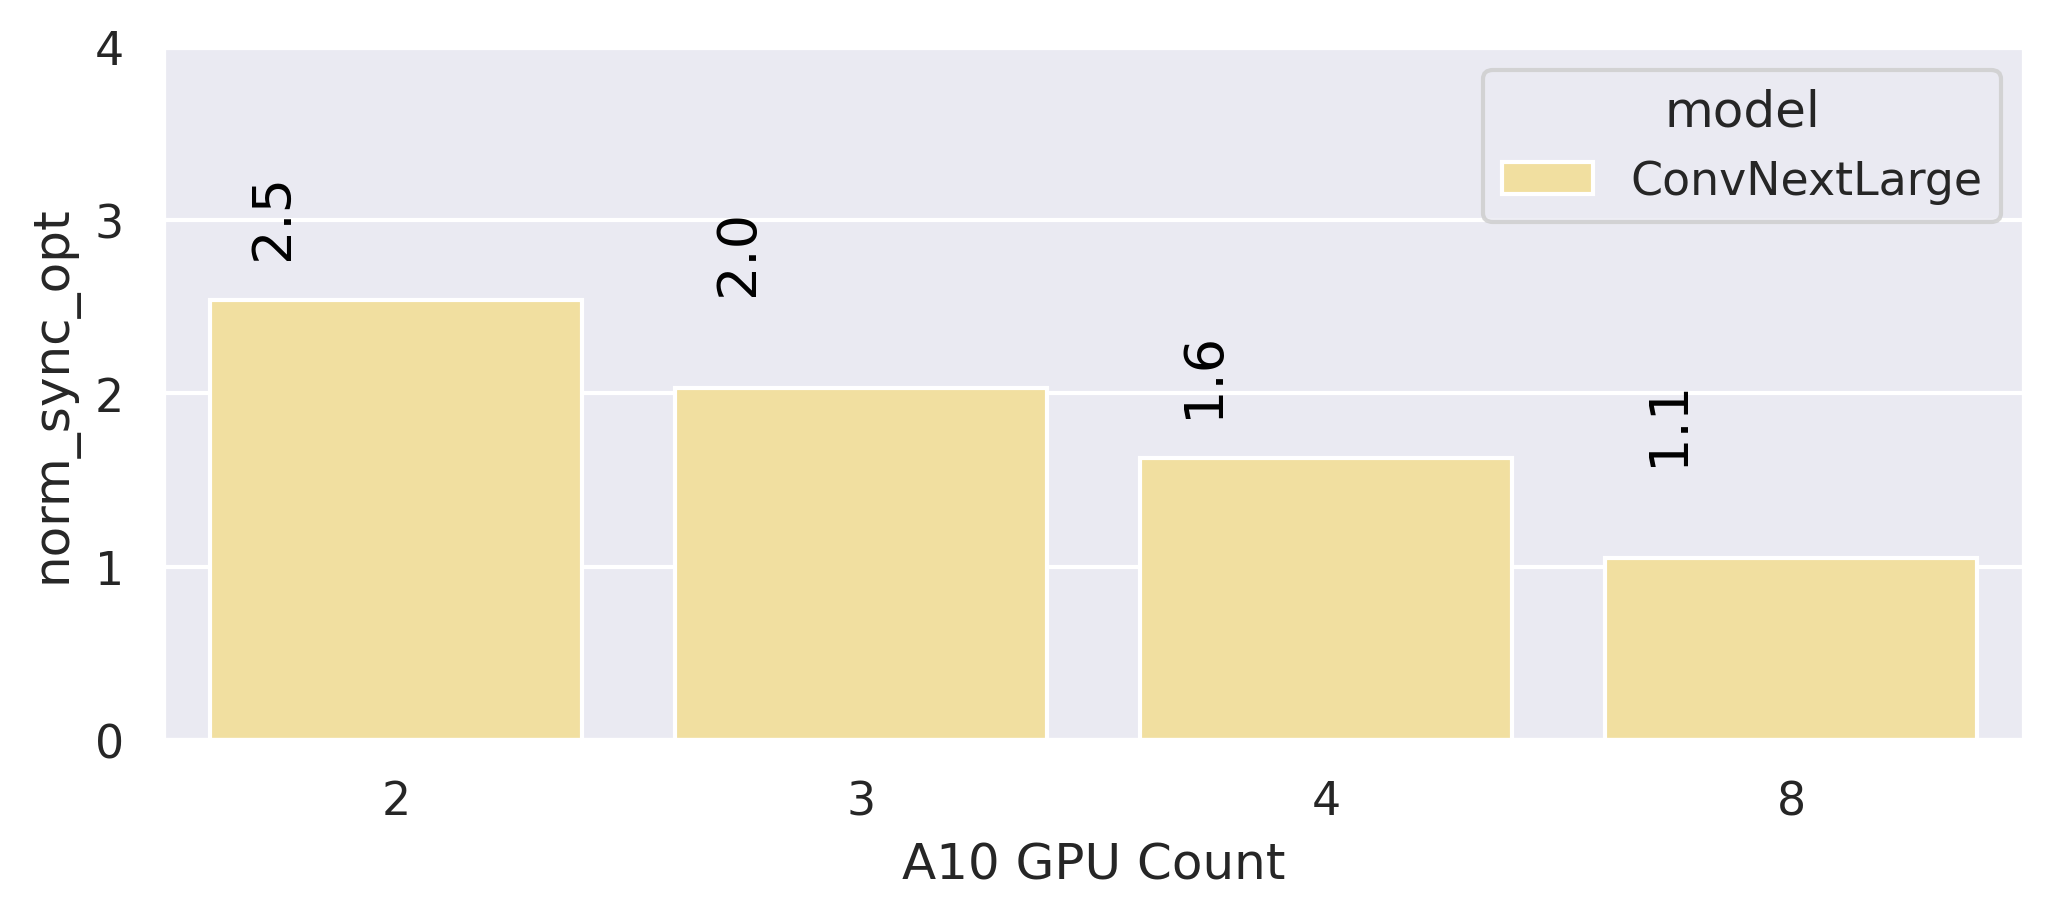

In [13]:
temp_df = cv_A10_timing_df.query("TBS==32768 and model=='ConvNextLarge' and gpu_count!=1")
temp_df["norm_sync_opt"] = temp_df["sync_opt"] / temp_df["gpu_count"]

sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=temp_df,
    x="gpu_count",
    y="norm_sync_opt",
    hue="model")
#plt.ylabel("Average Norm. Sync\n opt.step() in Seconds")
plt.xlabel("A10 GPU Count")
plt.ylim(0, 4)
#sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
#round_bar_value_multi(ax, decimals=1)
show_values_on_barplot(ax, height=0.3, rotation=90, decimals=1, fontsize=13)

## Over TBS

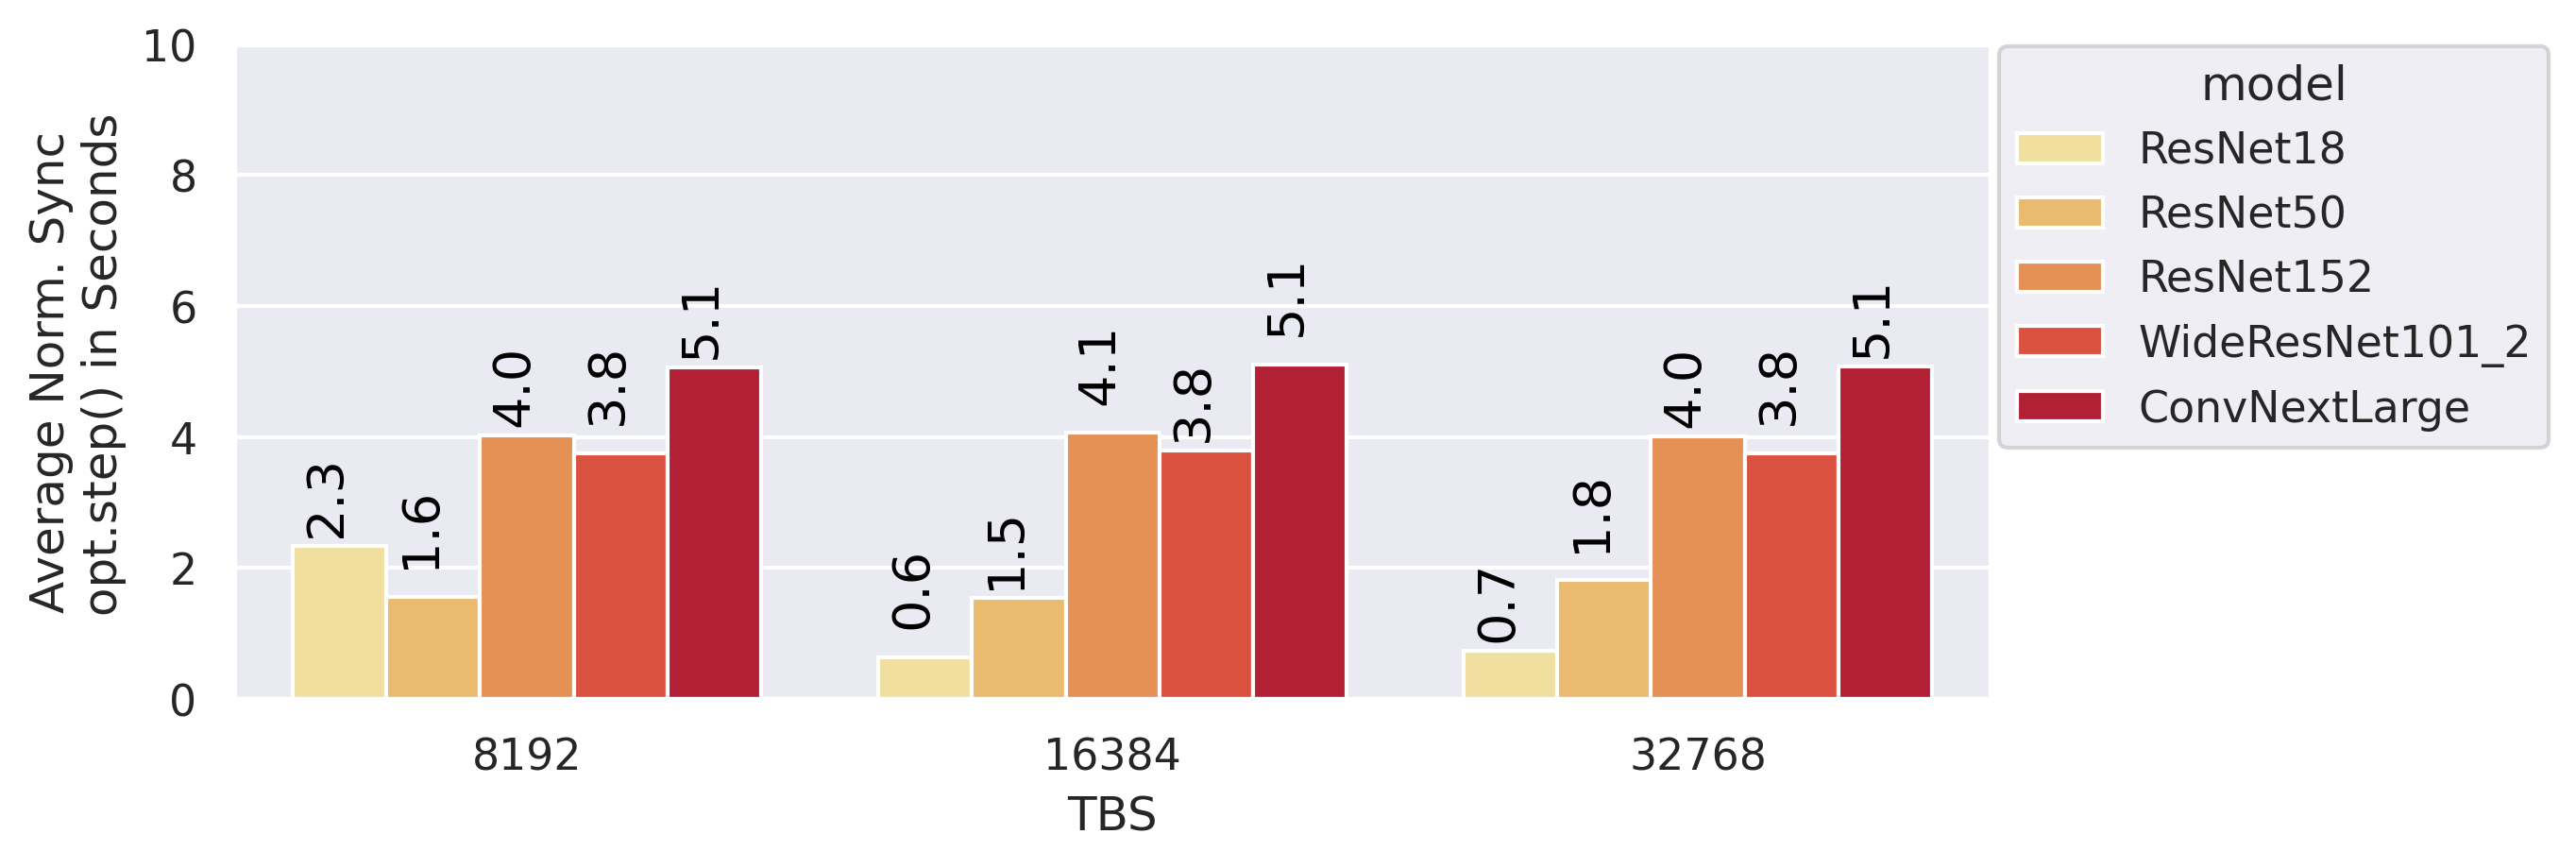

In [14]:
sns.set(palette=cv_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=cv_A10_timing_df.query("gpu_count==2 and (TBS==8192 or TBS==16384 or TBS==32768)"),
    x="TBS",
    y="sync_opt",
    hue="model")
plt.ylabel("Average Norm. Sync\n opt.step() in Seconds")
plt.xlabel("TBS")
plt.ylim(0, 10)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
#round_bar_value_multi(ax, decimals=1)
show_values_on_barplot(ax, height=0.3, rotation=90, decimals=1, fontsize=13)

# CV Cloud Experiments

In [15]:
cv_2xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-81",  val_dict={"domain":"CV", "gpu_count": 2, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})
cv_4xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-77",  val_dict={"domain":"CV", "gpu_count": 4, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})
cv_6xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-114", val_dict={"domain":"CV", "gpu_count": 6, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})
cv_8xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-79",  val_dict={"domain":"CV", "gpu_count": 8, "type": "US T4", "model": "ConvNextLarge", "TBS": 32768})

nlp_2xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-82",   val_dict={"domain":"NLP", "gpu_count": 2, "type": "US T4", "model": "RobertaXLM", "TBS": 32768 })
nlp_4xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-78",   val_dict={"domain":"NLP", "gpu_count": 4, "type": "US T4", "model": "RobertaXLM", "TBS": 32768 })
nlp_6xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-115",  val_dict={"domain":"NLP", "gpu_count": 6, "type": "US T4", "model": "RobertaXLM", "TBS": 32768 })
nlp_8xUS_T4_timing_df = auto_hivemind_timing_summary(run_name="hivemind-80",   val_dict={"domain":"NLP", "gpu_count": 8, "type": "US T4", "model": "RobertaXLM", "TBS": 32768 })

cloud_US_T4_timings_df = pd.concat(objs=[
    cv_2xUS_T4_timing_df,
    cv_4xUS_T4_timing_df,
    cv_6xUS_T4_timing_df,
    cv_8xUS_T4_timing_df,
    nlp_2xUS_T4_timing_df,
    nlp_4xUS_T4_timing_df,
    nlp_6xUS_T4_timing_df,
    nlp_8xUS_T4_timing_df,    
])
cloud_US_T4_timings_df = cloud_US_T4_timings_df.reset_index(drop=True)
cloud_US_T4_timings_df

> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 6 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


,traintime_wo_opt,noop_opt,sync_opt,forward_s,backward_s,domain,gpu_count,type,model,TBS,name
0,0.405456,0.111202,6.587555,0.026019,0.366304,CV,2,US T4,ConvNextLarge,32768,hivemind-81
1,0.393959,0.110263,8.845532,0.026312,0.355463,CV,4,US T4,ConvNextLarge,32768,hivemind-77
2,0.405782,0.113230,10.574507,0.026322,0.367260,CV,6,US T4,ConvNextLarge,32768,hivemind-114
3,0.400088,0.112981,12.091843,0.027788,0.359815,CV,8,US T4,ConvNextLarge,32768,hivemind-79
4,0.166596,0.018967,13.766635,0.032318,0.124102,NLP,2,US T4,RobertaXLM,32768,hivemind-82
5,0.164177,0.019748,17.137221,0.033046,0.121039,NLP,4,US T4,RobertaXLM,32768,hivemind-78
6,0.165061,0.020890,18.855346,0.033970,0.119720,NLP,6,US T4,RobertaXLM,32768,hivemind-115
7,0.169684,0.021962,20.834533,0.035664,0.119405,NLP,8,US T4,RobertaXLM,32768,hivemind-80


/tmp/ipykernel_23052/1672597447.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a10_temp_df["type"] = "US A10"
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


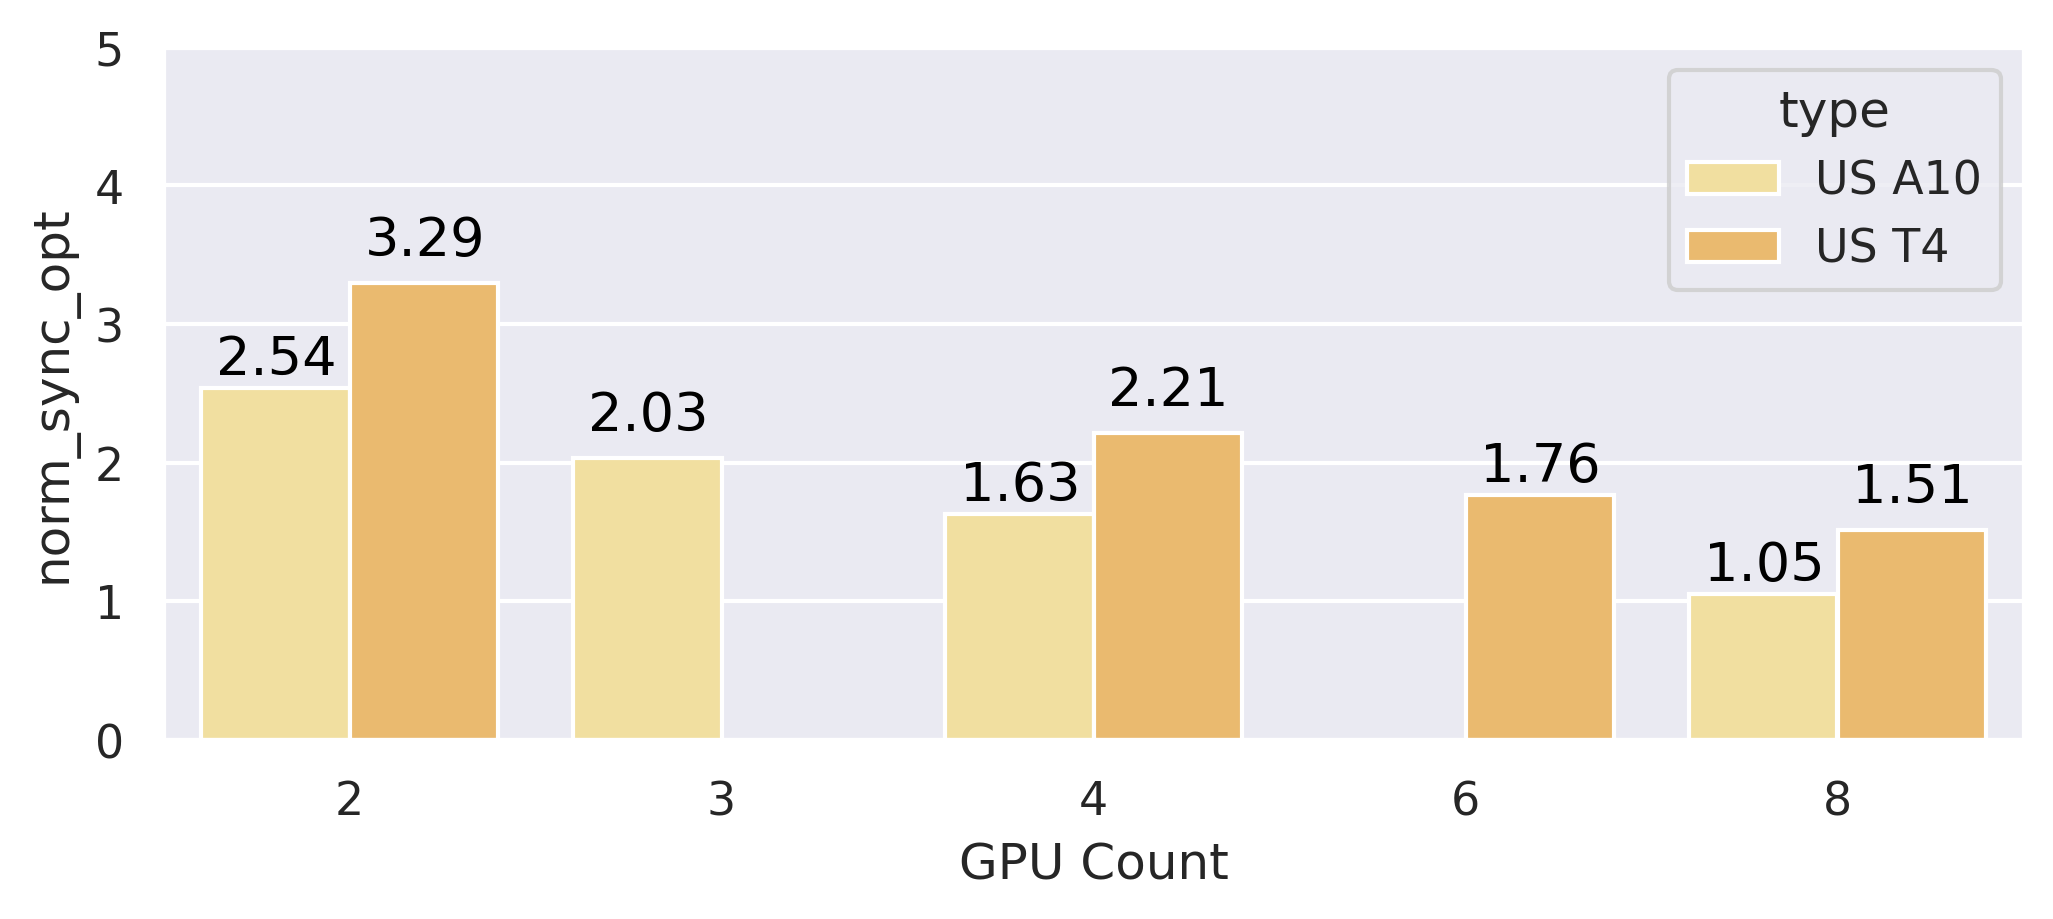

In [16]:
#sns.set(palette=cv_palette)
a10_temp_df = cv_A10_timing_df.query("TBS==32768 and model=='ConvNextLarge' and gpu_count!=1")
a10_temp_df["type"] = "US A10"
t4_temp_df = cloud_US_T4_timings_df.query("domain=='CV'")


temp_df = pd.concat(objs=[a10_temp_df, t4_temp_df])
temp_df = temp_df.reset_index(drop=True)
temp_df["norm_sync_opt"] = temp_df["sync_opt"] / temp_df["gpu_count"]

plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=temp_df,
    x="gpu_count",
    y="norm_sync_opt",
    hue="type")
#plt.ylabel("Average Traintime\n w/o opt.step()\n in Seconds")
plt.xlabel("GPU Count")
plt.ylim(0,5)
#sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
show_values_on_barplot(ax, height=0.1, rotation=0, decimals=2, fontsize=13)

# NLP

In [17]:
nlp_a10_baseline_timing_df = auto_baseline_timing_summaries(run_names=[
    "baseline-167-roberta_mlm_base", #"baseline-15-roberta_mlm_base",
    "baseline-168-roberta_mlm_base", #"baseline-16-roberta_mlm_base",
    "baseline-169-roberta_mlm_base", #"baseline-17-roberta_mlm_base",
    "baseline-18-roberta_mlm_large",
    "baseline-19-roberta_mlm_large",
    "baseline-20-roberta_mlm_large",
    "baseline-21-roberta_mlm_xlm",
    "baseline-22-roberta_mlm_xlm",
    "baseline-23-roberta_mlm_xlm",
    ])
nlp_a10_baseline_timing_df = rename_models(df = nlp_a10_baseline_timing_df)
nlp_a10_baseline_timing_df["gpu_count"] = int(1)
nlp_a10_baseline_timing_df["gpu_type"] = "A10"

rBse_2xA10_8192_timing_df = auto_hivemind_timing_summary(run_name="hivemind-297",  val_dict={"model": "RoBERTaBase" , "TBS": 8192})
rLrg_2xA10_8192_timing_df = auto_hivemind_timing_summary(run_name="hivemind-298",   val_dict={"model": "RoBERTaLarge", "TBS": 8192})
rXLM_2xA10_8192_timing_df = auto_hivemind_timing_summary(run_name="hivemind-299",   val_dict={"model": "RoBERTaXLM"  , "TBS": 8192})

rBse_2xA10_16384_timing_df = auto_hivemind_timing_summary(run_name="hivemind-300", val_dict={"model": "RoBERTaBase" , "TBS": 16384})
rLrg_2xA10_16384_timing_df = auto_hivemind_timing_summary(run_name="hivemind-301",  val_dict={"model": "RoBERTaLarge", "TBS": 16384})
rXLM_2xA10_16384_timing_df = auto_hivemind_timing_summary(run_name="hivemind-302",  val_dict={"model": "RoBERTaXLM"  , "TBS": 16384})

rBse_2xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-303", val_dict={"model": "RoBERTaBase" , "TBS": 32768})
rLrg_2xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-304",  val_dict={"model": "RoBERTaLarge", "TBS": 32768})
rXLM_2xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-305",  val_dict={"model": "RoBERTaXLM"  , "TBS": 32768})

nlp_2x10_timings_df = pd.concat(objs=[
    rBse_2xA10_8192_timing_df,
    rLrg_2xA10_8192_timing_df,
    rXLM_2xA10_8192_timing_df,
    rBse_2xA10_16384_timing_df,
    rLrg_2xA10_16384_timing_df,
    rXLM_2xA10_16384_timing_df,
    rBse_2xA10_32768_timing_df,
    rLrg_2xA10_32768_timing_df,
    rXLM_2xA10_32768_timing_df
])

nlp_2x10_timings_df = nlp_2x10_timings_df.reset_index(drop=True)
nlp_2x10_timings_df["gpu_count"] = int(2)
nlp_2x10_timings_df["gpu_type"] = "A10"

rBse_3xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-311", val_dict={"model": "RoBERTaBase" , "TBS": 32768})
rLrg_3xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-312",  val_dict={"model": "RoBERTaLarge", "TBS": 32768})
rXLM_3xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-313",  val_dict={"model": "RoBERTaXLM"  , "TBS": 32768})
nlp_3x10_timings_df = pd.concat(objs=[
    rBse_3xA10_32768_timing_df,
    rLrg_3xA10_32768_timing_df,
    rXLM_3xA10_32768_timing_df
])
nlp_3x10_timings_df = nlp_3x10_timings_df.reset_index(drop=True)
nlp_3x10_timings_df["gpu_count"] = int(3)
nlp_3x10_timings_df["gpu_type"] = "A10"
                                                                                             
rBse_4xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-320", val_dict={"model": "RoBERTaBase" , "TBS": 32768})
rLrg_4xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-321",  val_dict={"model": "RoBERTaLarge", "TBS": 32768})
rXLM_4xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-322",  val_dict={"model": "RoBERTaXLM"  , "TBS": 32768})
nlp_4x10_timings_df = pd.concat(objs=[
    rBse_4xA10_32768_timing_df,
    rLrg_4xA10_32768_timing_df,
    rXLM_4xA10_32768_timing_df
])
nlp_4x10_timings_df = nlp_4x10_timings_df.reset_index(drop=True)
nlp_4x10_timings_df["gpu_count"] = int(4)
nlp_4x10_timings_df["gpu_type"] = "A10"

rBse_8xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-331", val_dict={"model": "RoBERTaBase" , "TBS": 32768})
rLrg_8xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-332",  val_dict={"model": "RoBERTaLarge", "TBS": 32768})
rXLM_8xA10_32768_timing_df = auto_hivemind_timing_summary(run_name="hivemind-333",  val_dict={"model": "RoBERTaXLM"  , "TBS": 32768})
nlp_8x10_timings_df = pd.concat(objs=[
    rBse_8xA10_32768_timing_df,
    rLrg_8xA10_32768_timing_df,
    rXLM_8xA10_32768_timing_df
])
nlp_8x10_timings_df = nlp_8x10_timings_df.reset_index(drop=True)
nlp_8x10_timings_df["gpu_count"] = int(8)
nlp_8x10_timings_df["gpu_type"] = "A10"

nlp_A10_timing_df = pd.concat(objs=[
    nlp_a10_baseline_timing_df,
    nlp_2x10_timings_df,
    nlp_3x10_timings_df,
    nlp_4x10_timings_df,
    nlp_8x10_timings_df
])
nlp_A10_timing_df = nlp_A10_timing_df.reset_index(drop=True)
nlp_A10_timing_df["sync_opt_norm"] = nlp_A10_timing_df["sync_opt"] / nlp_A10_timing_df["TBS"]
#nlp_A10_timing_df

> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 2 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 3 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 4 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.
> Found 8 runs with the infix 'bee'.


# NLP Training Time without `opt.step()`

## Over GPUs

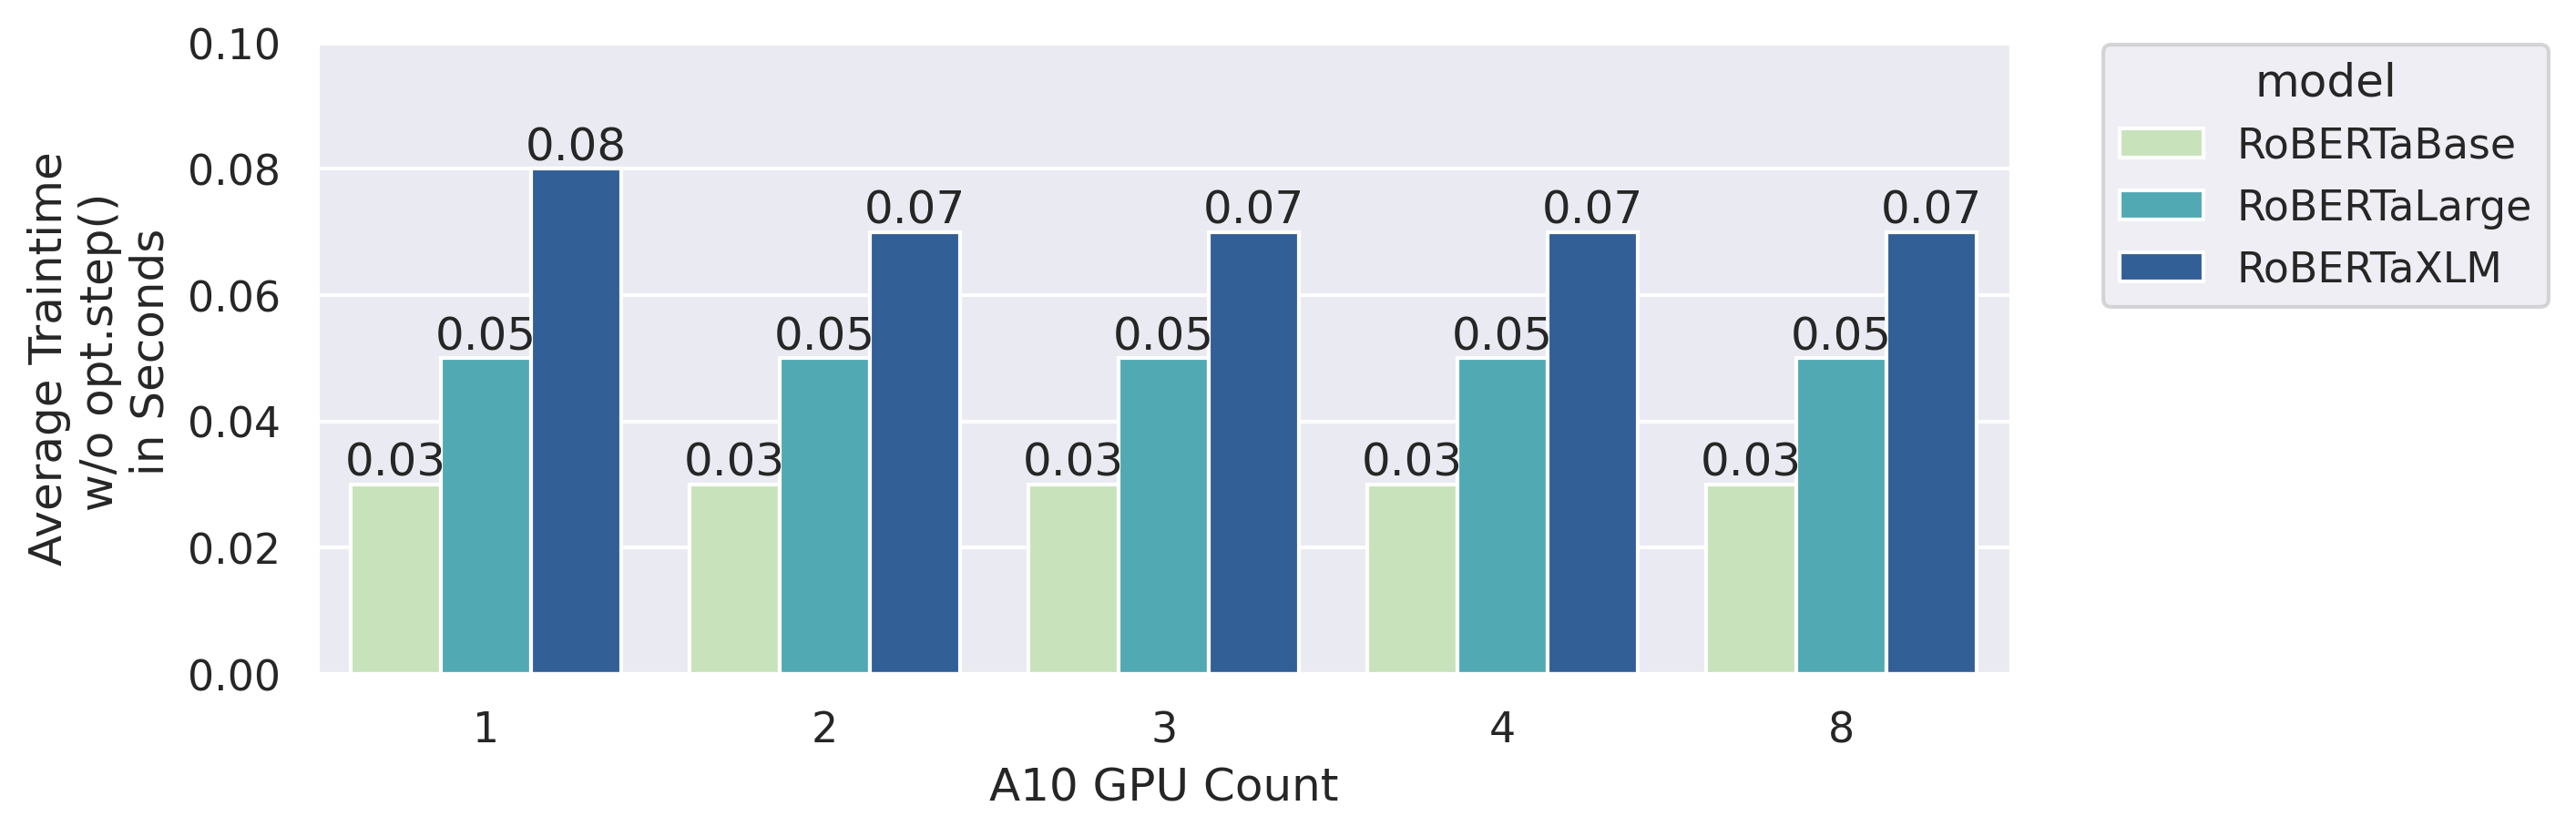

In [18]:
sns.set(palette=nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=nlp_A10_timing_df.query("TBS==32768"),
    x="gpu_count",
    y="traintime_wo_opt",
    hue="model")
plt.ylabel("Average Traintime\n w/o opt.step()\n in Seconds")
plt.xlabel("A10 GPU Count")
plt.ylim(0, 0.10)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
round_bar_value_multi(ax, decimals=2)
#show_values_on_barplot(ax, height=0.002, rotation=90, decimals=3, fontsize=13)

## Over TBS

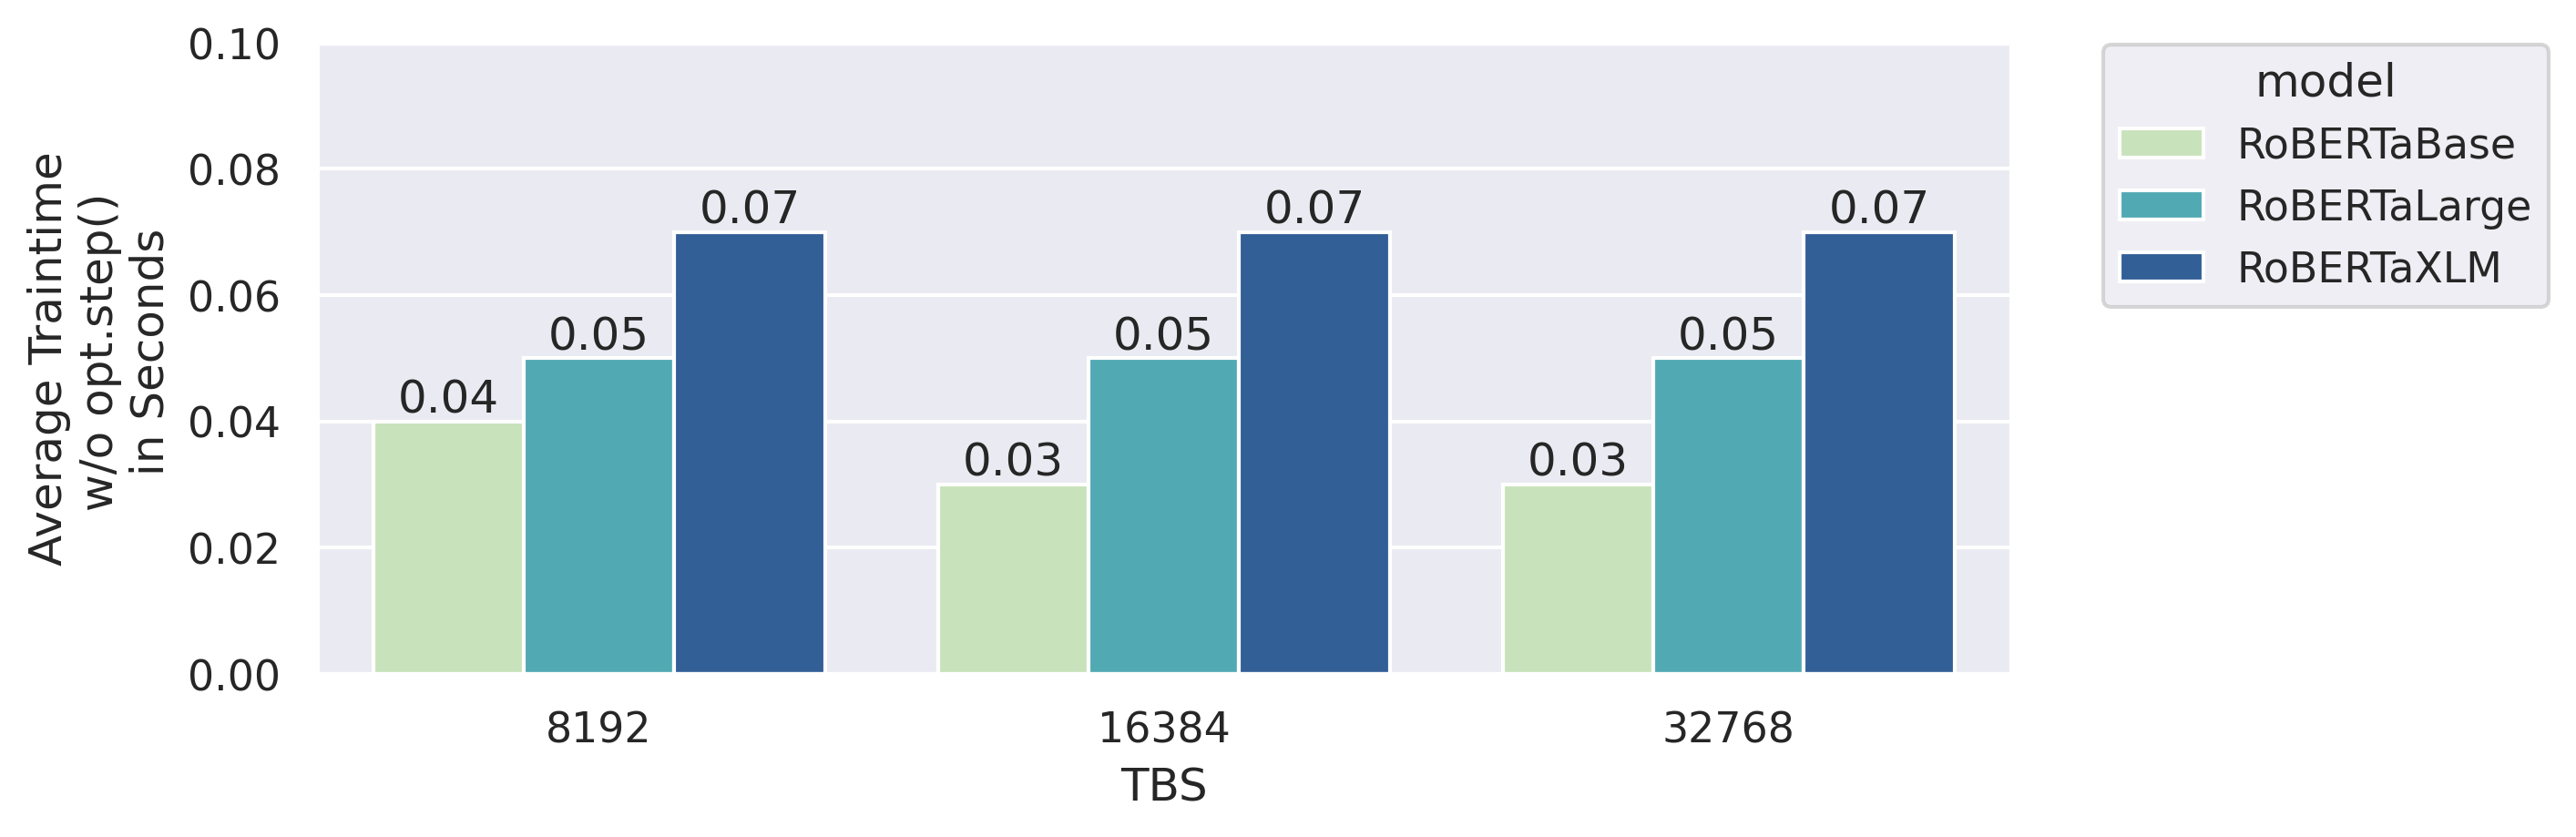

In [19]:
sns.set(palette=nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=nlp_A10_timing_df.query("gpu_count==2"),
    x="TBS",
    y="traintime_wo_opt",
    hue="model")
plt.ylabel("Average Traintime\n w/o opt.step()\n in Seconds")
plt.xlabel("TBS")
plt.ylim(0, 0.10)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
round_bar_value_multi(ax, decimals=2)
#show_values_on_barplot(ax, height=0.002, rotation=90, decimals=3, fontsize=13)

# NLP no-op `opt.step()` time

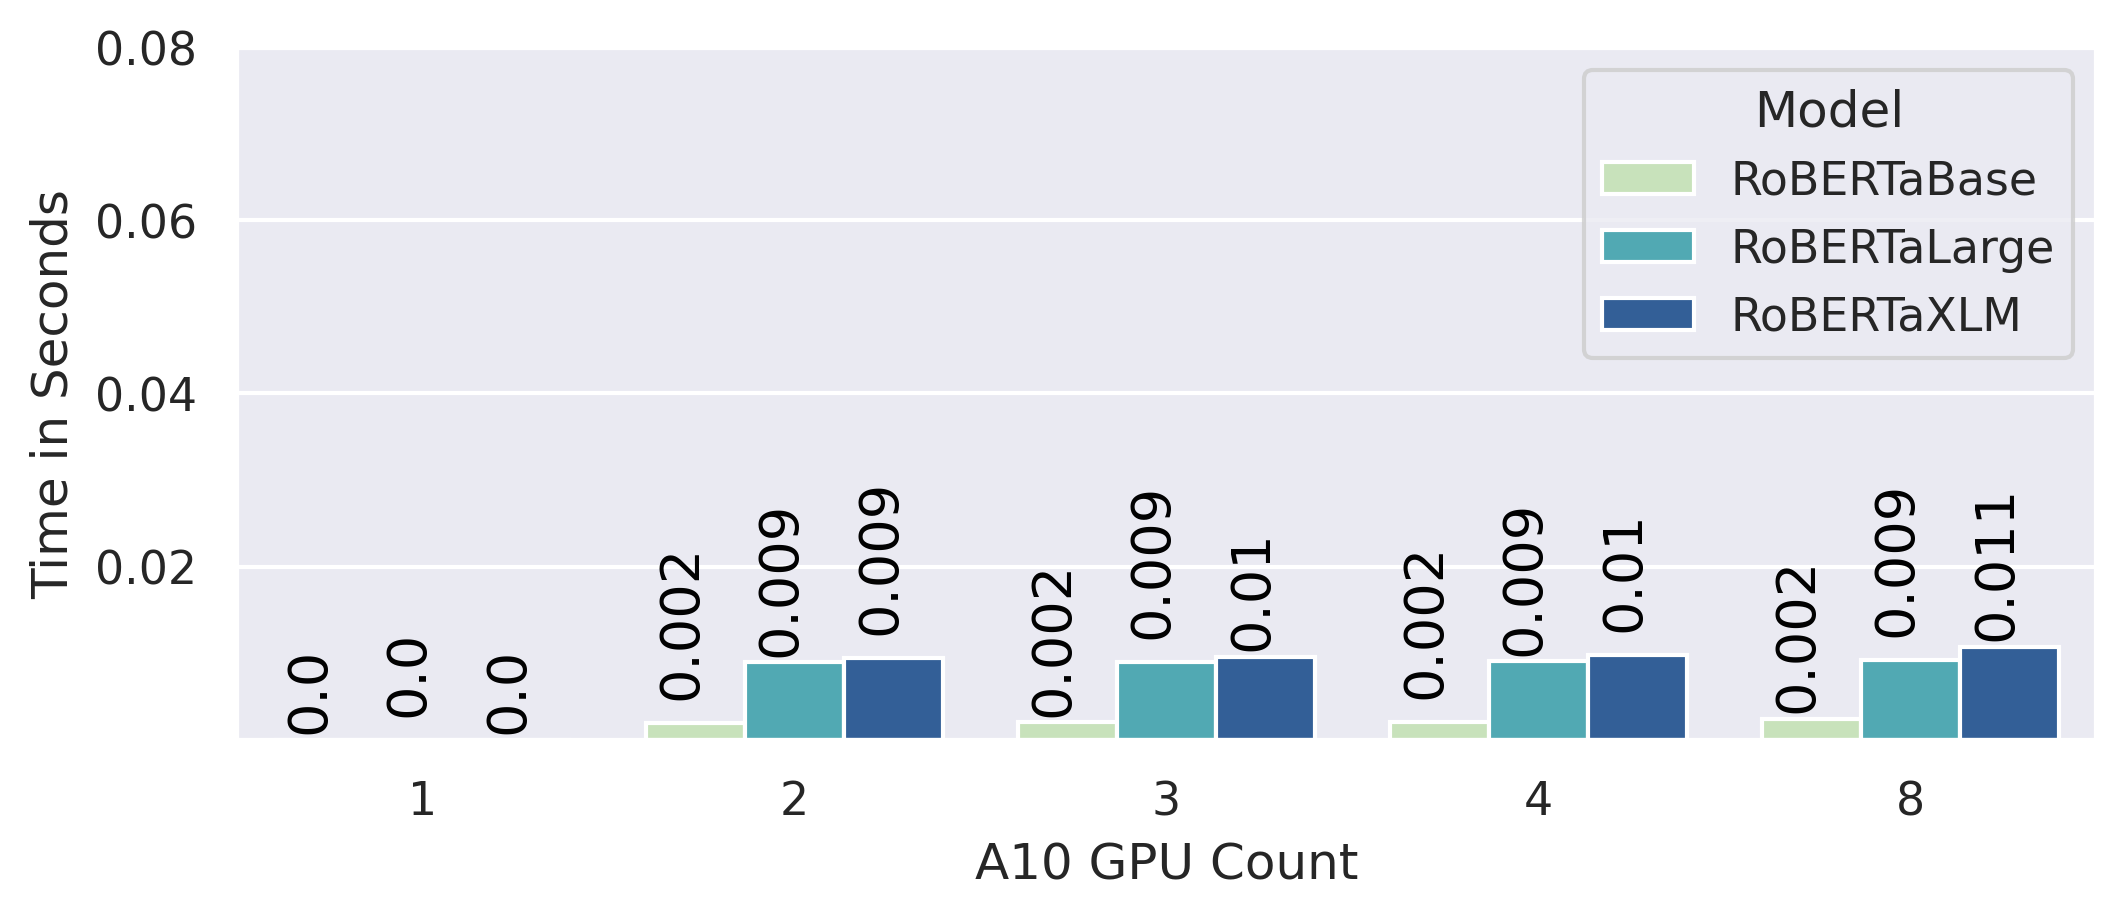

In [20]:
sns.set(palette=nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=nlp_A10_timing_df.query("TBS==32768"),# and (gpu_count==1 or gpu_count==2)"),
    x="gpu_count",
    y="noop_opt",
    hue="model")
    #log=True)
#plt.ylabel("No-Sync opt.step()\n Time in Seconds")
plt.ylabel("Time in Seconds")
plt.xlabel("A10 GPU Count")
plt.ylim(0.000001,0.08)
#sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
#round_bar_value_multi(ax, decimals=2)
plt.legend(title="Model")
show_values_on_barplot(ax, height=0.002, rotation=90, decimals=3, fontsize=13)
save_fig(f"nlp_32768_noop_step")

# NLP sync `opt.step()` time

## Over GPUs

/tmp/ipykernel_23052/4116199964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["norm_sync_opt"] = temp_df["sync_opt"] / temp_df["gpu_count"]


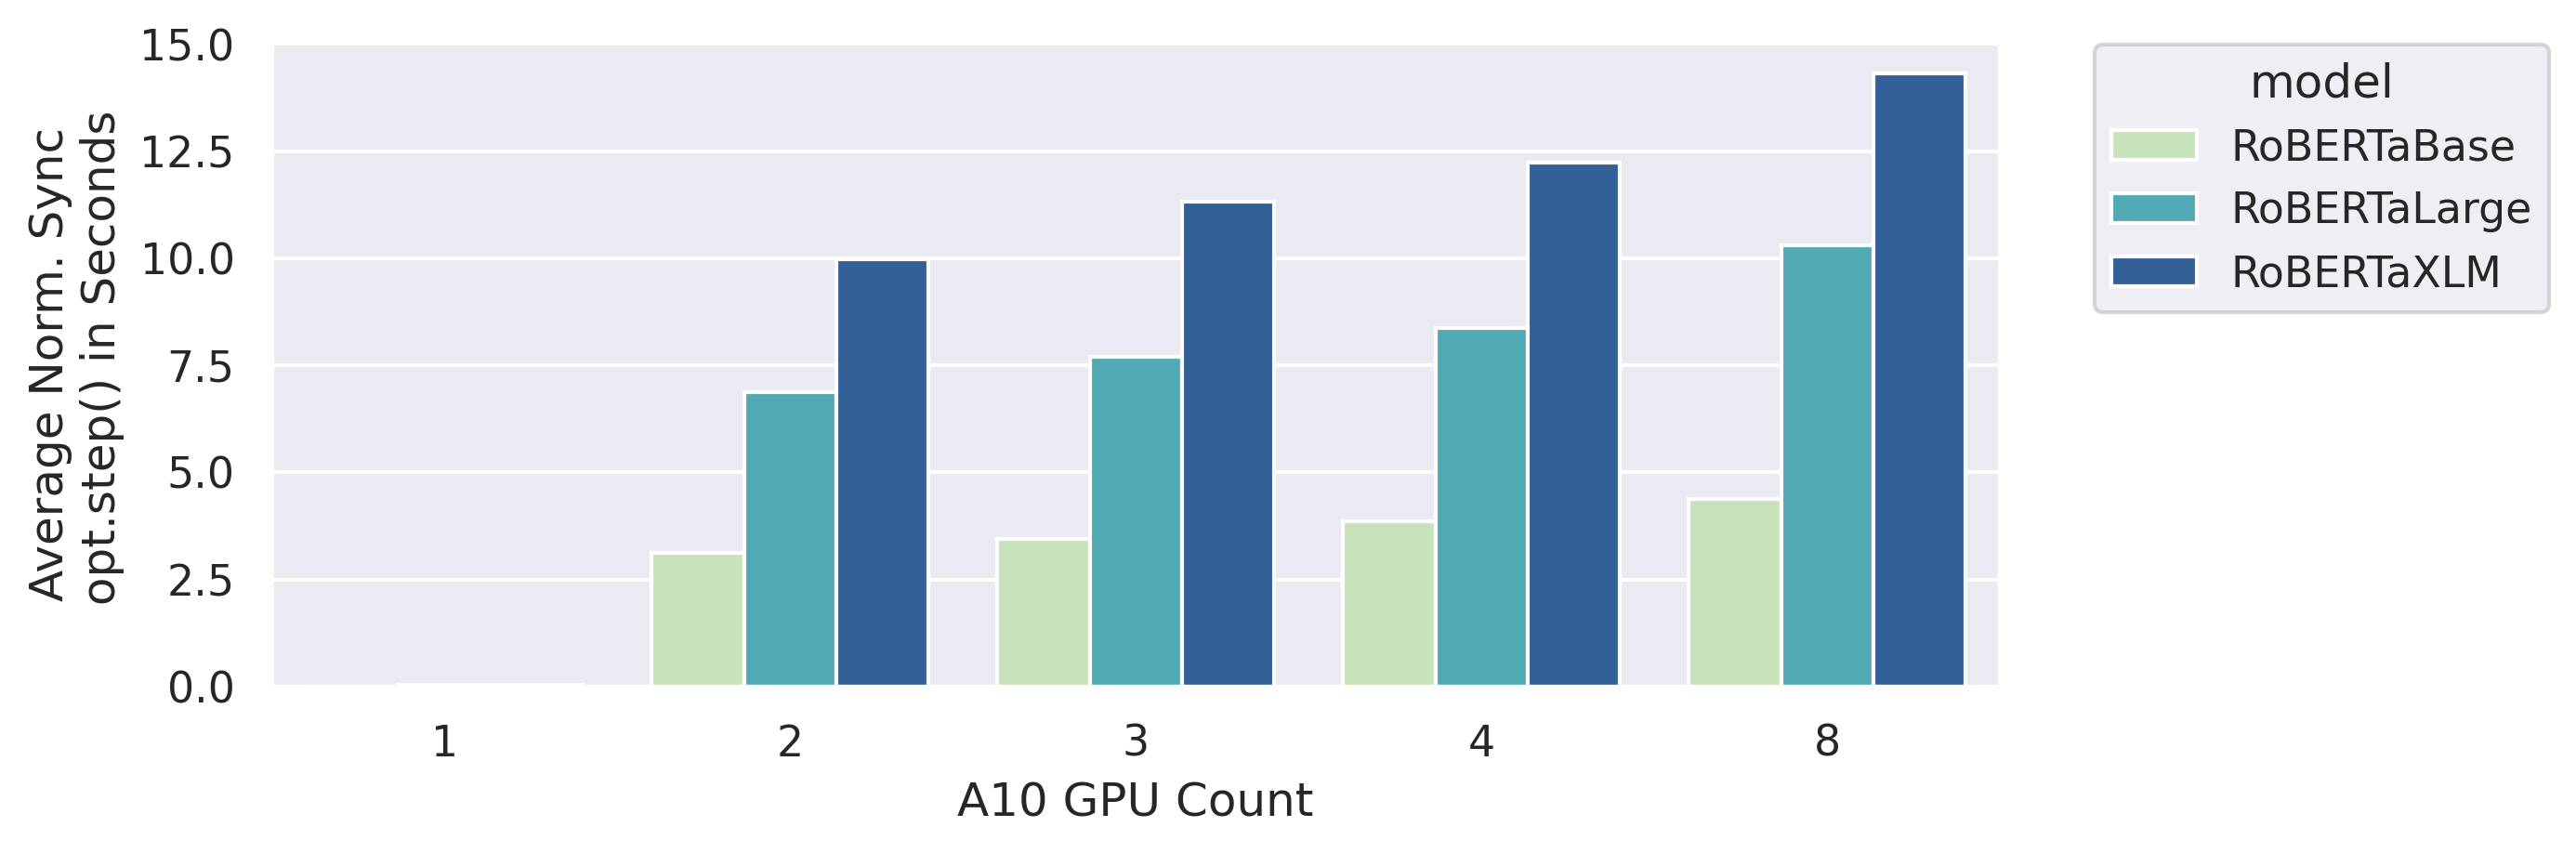

In [21]:
temp_df = nlp_A10_timing_df.query("TBS==32768")
temp_df["norm_sync_opt"] = temp_df["sync_opt"] / temp_df["gpu_count"]

sns.set(palette=nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=temp_df,
    x="gpu_count",
    y="sync_opt",
    #y="backward_s",
    hue="model")
plt.ylabel("Average Norm. Sync\n opt.step() in Seconds")
plt.xlabel("A10 GPU Count")
#plt.ylim(0,0.001)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
#round_bar_value_multi(ax, decimals=1)
#show_values_on_barplot(ax, height=0.00003, rotation=90, decimals=7, fontsize=13)

/tmp/ipykernel_23052/511014021.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df["norm_sync_opt"] = temp_df["sync_opt"] / temp_df["gpu_count"]


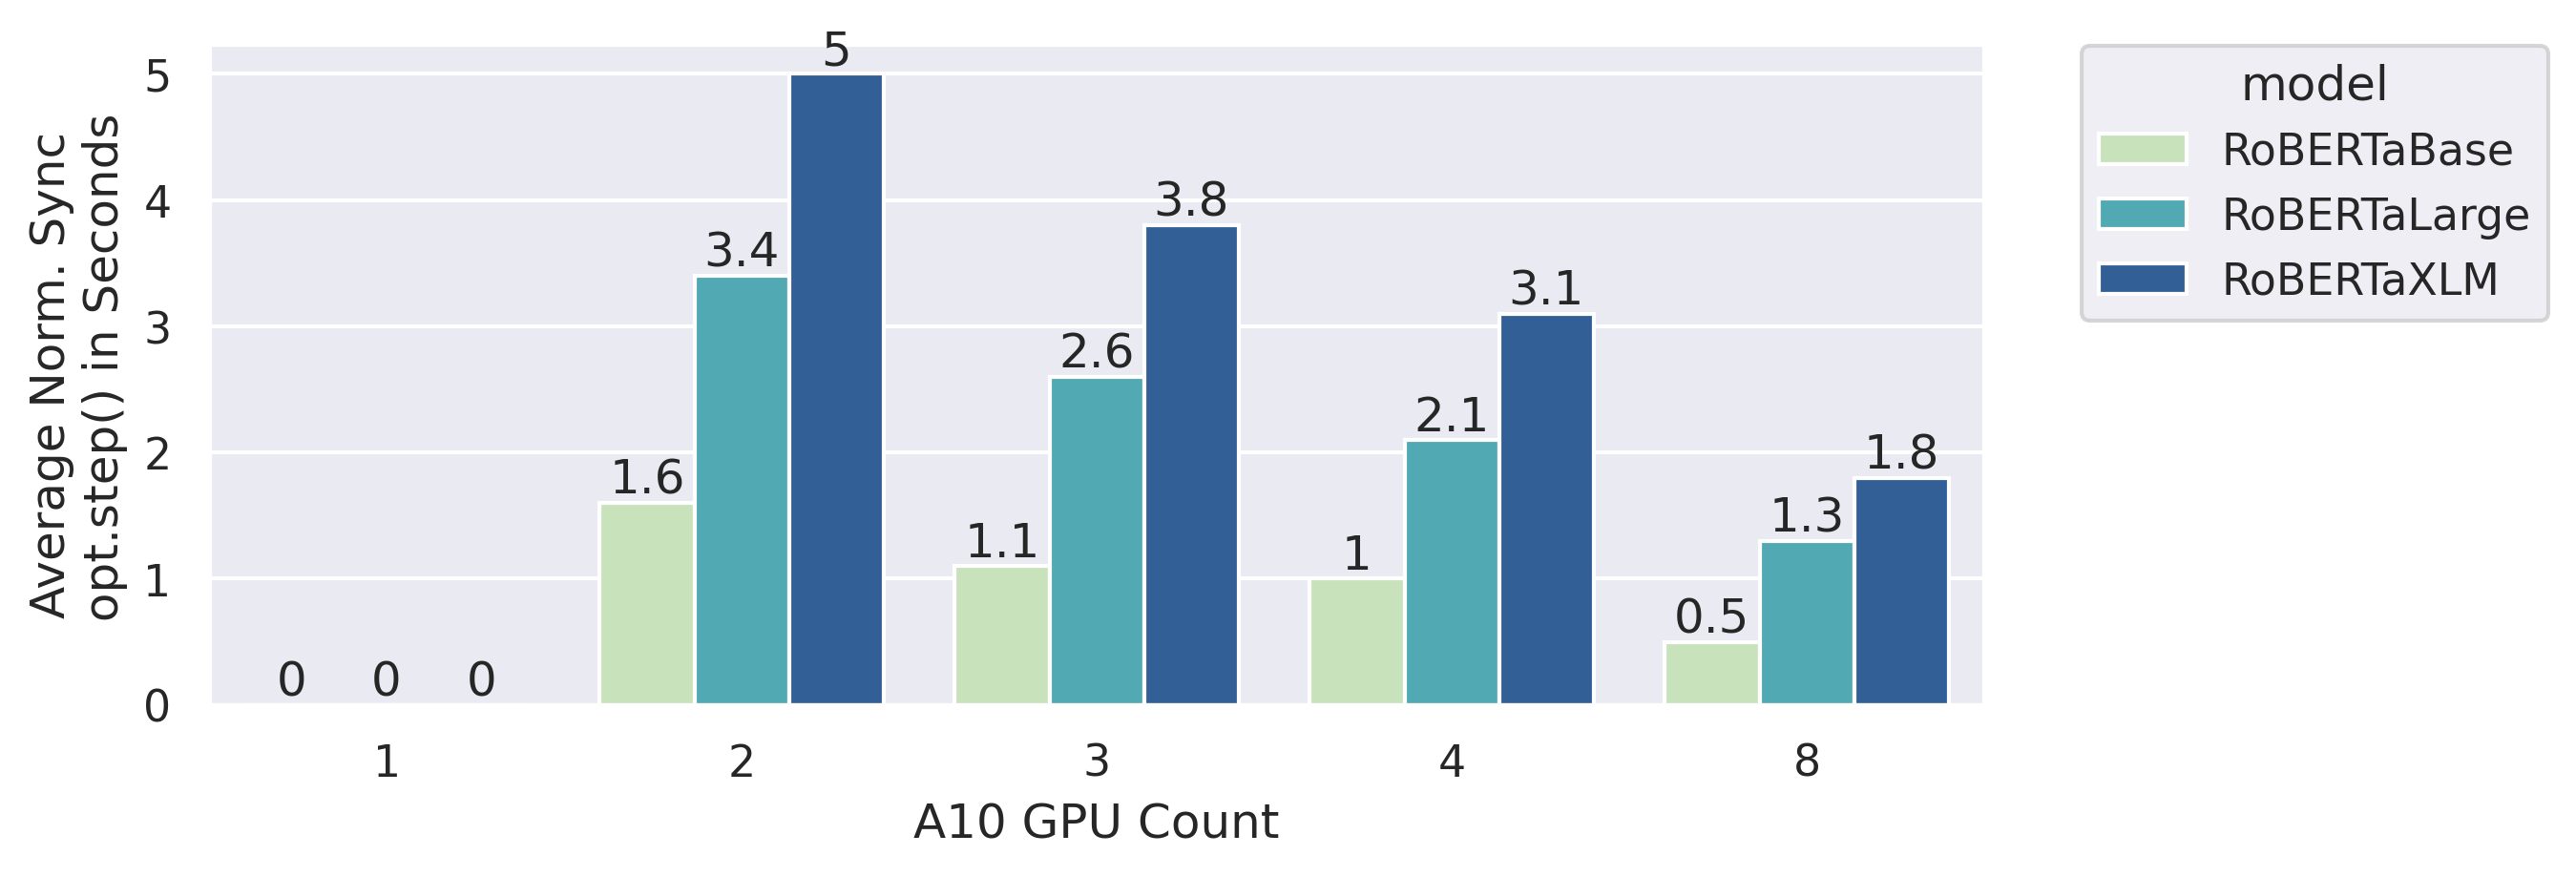

In [22]:
temp_df = nlp_A10_timing_df.query("TBS==32768")
temp_df["norm_sync_opt"] = temp_df["sync_opt"] / temp_df["gpu_count"]

sns.set(palette=nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=temp_df,
    x="gpu_count",
    y="norm_sync_opt",
    #y="backward_s",
    hue="model")
plt.ylabel("Average Norm. Sync\n opt.step() in Seconds")
plt.xlabel("A10 GPU Count")
#plt.ylim(0,0.001)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
round_bar_value_multi(ax, decimals=1)
#show_values_on_barplot(ax, height=0.00003, rotation=90, decimals=7, fontsize=13)

## Over TBS

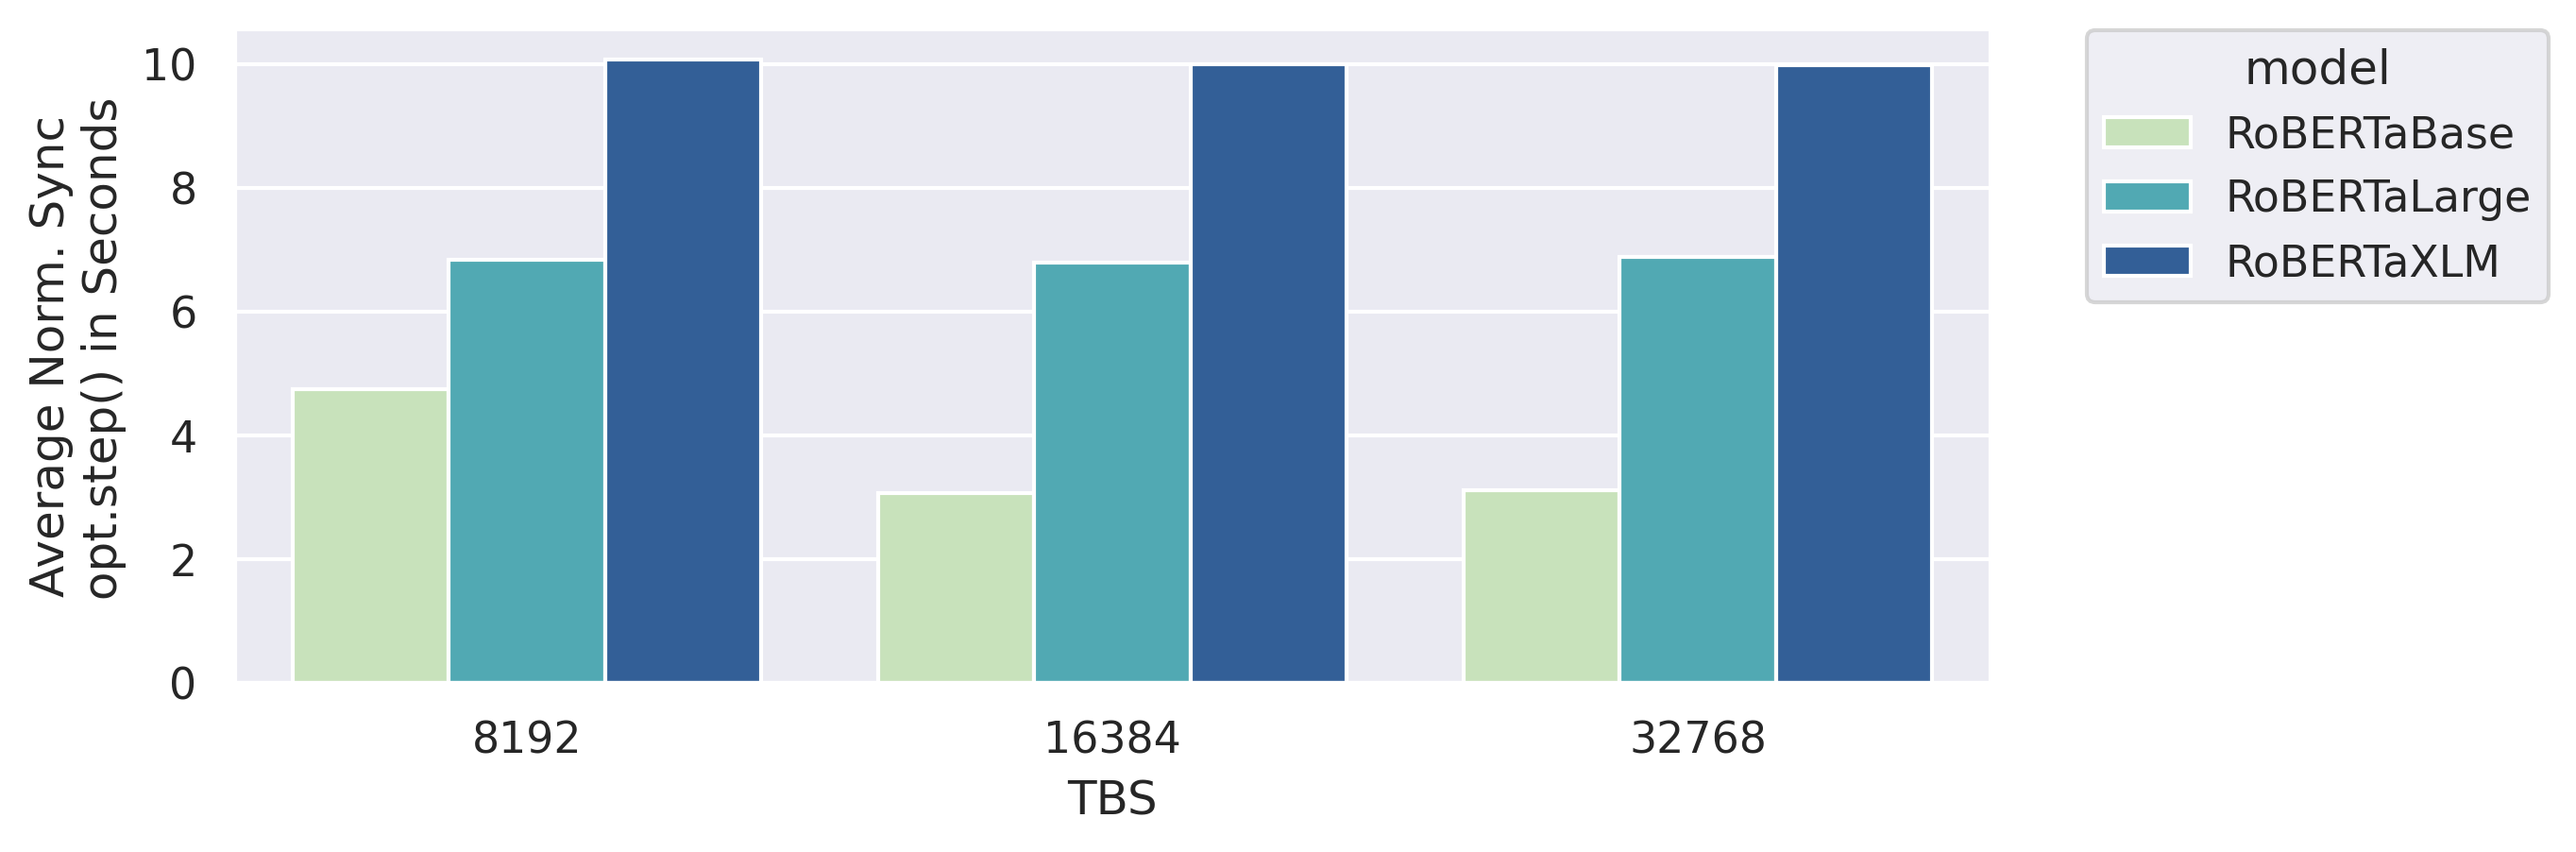

In [23]:
sns.set(palette=nlp_palette)
plt.figure(figsize=(8,3))
ax = sns.barplot(
    data=nlp_A10_timing_df.query("gpu_count==2"),
    x="TBS",
    y="sync_opt",
    hue="model")
plt.ylabel("Average Norm. Sync\n opt.step() in Seconds")
plt.xlabel("TBS")
#plt.ylim(0,0.004)
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.33, 1.03))
#round_bar_value_multi(ax, decimals=1)
#show_values_on_barplot(ax, height=0.0001, rotation=90, decimals=7, fontsize=13)